# Model Replication

In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
from scipy.stats import levene
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns

plt.rcParams['figure.dpi'] = 600
colors = plt.colormaps["Dark2"].colors
from tqdm import tqdm

# silence warnings because the NN has a lot of them
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from optuna import create_study
from optuna.trial import Trial
from tensorflow.keras import backend as K
import random

# for saving model params
import pickle

# for feature importance
import shap
from sklearn.metrics import mean_squared_error
import copy
import ast

In [2]:
### CONDITION-LEVEL DATA
df_condition_level_data = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs.csv') # mark's version of the cleaning

# add in categorical task types
df_condition_data_with_mcgrath_types = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs_and_categories.csv')
mcgrath_cols = df_condition_data_with_mcgrath_types.filter(like="Type").columns
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types[["task"] + list(mcgrath_cols)].drop_duplicates()
# rename the mcgrath columns to have the suffix "_categorical"
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types.rename(columns={col: col + "_categorical" for col in mcgrath_cols})
df_condition_level_data = df_condition_level_data.merge(df_condition_data_with_mcgrath_types, on="task", how="left")

In [3]:
# inspect data, just to get a sense of the range of values.
df_condition_level_data[["task", "strong", "High", "Medium", "Low"]].sort_values("strong", ascending=False)

,task,strong,High,Medium,Low
39,Putting Food Into Categories,1.659080,0,1,0
113,Word Construction,1.627765,1,0,0
80,Unscramble Words,1.627760,0,1,0
37,Putting Food Into Categories,1.606875,0,0,1
41,Putting Food Into Categories,1.534374,1,0,0
...,...,...,...,...,...
5,Advertisement Writing,0.443447,1,0,0
3,Advertisement Writing,0.417235,0,1,0
89,Whac a Mole,0.331275,1,0,0
45,Random Dot Motion,0.297844,0,1,0


In [4]:
df_observation_level_data = pd.read_csv('../outputs/observation_level_dv_with_composition.csv')

In [5]:
FOCAL_DEMOGRAPHIC_COLS = ['IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS',
						'RME', 'CRT', 'birth_year', 'education_level', 'income_max', 'political_fiscal', 'political_party', 'political_social',
						'gender', 'race', 'marital_status']

COMPOSITION_IVS = [col for col in df_observation_level_data.columns if any(col.startswith(prefix) for prefix in FOCAL_DEMOGRAPHIC_COLS)]
COMPOSITION_IVS = COMPOSITION_IVS + ["playerCount", "Low", "Medium", "High"]

# p-value check: Within-Task Type Variance

"...there is almost as much within-category variation as exists overall."

In [6]:
mcgrath_cat_cols = df_condition_data_with_mcgrath_types.filter(like="_cat").columns
cat_col = df_condition_level_data[mcgrath_cat_cols].idxmax(axis=1)
df_condition_level_data_with_cat = df_condition_level_data.assign(cat_col=cat_col)

# Aggregate and summarize data by category
categorical_condition_summary = df_condition_level_data_with_cat.groupby("cat_col").agg({
    "strong": ["mean", "std", "count"],
    "weak": ["mean", "std", "count"]
}).reset_index()

# categorical level summary
display(categorical_condition_summary)

# display the strong and weak values for the entire dataset
display(df_condition_level_data["strong"].describe())
display(df_condition_level_data["weak"].describe())

strong_vals = df_condition_level_data["strong"]
weak_vals = df_condition_level_data["weak"]

strong_test_stats = []
weak_test_stats = []
strong_p_vals = []
weak_p_vals = []
df1_list = []
df2_list = []

# Iterate over each unique category to apply Levene's test
for cat in categorical_condition_summary['cat_col']:
    category_data = df_condition_level_data_with_cat[df_condition_level_data_with_cat['cat_col'] == cat]
    
    if category_data["strong"].count() > 6:
        cat_strong_vals = category_data["strong"]
        cat_weak_vals = category_data["weak"]

        # Levene's test comparing group variance to overall variance
        """
        The Levene test tests the null hypothesis that all input samples 
        are from populations with equal variances. Levene’s test is an 
        alternative to Bartlett’s test bartlett in the case where there 
        are significant deviations from normality.

        Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

        """
        W_stat_strong, p_val_strong = levene(cat_strong_vals, strong_vals)
        W_stat_weak, p_val_weak = levene(cat_weak_vals, weak_vals)

        # degrees of freedom
        """
        The degree of freedom df1 is obtained by calculating the number of groups minus 1,
        the degree of freedom df2 is obtained by calculating the number of cases minus the 
        number of groups.  Source: https://datatab.net/tutorial/levene-test
        """
        NUM_GROUPS = 2
        df1_list.append(NUM_GROUPS - 1)
        df2_list.append(len(cat_strong_vals) + len(strong_vals) - NUM_GROUPS)
        assert(len(cat_weak_vals) == len(cat_strong_vals)) # means we only need to calculate df once
        assert(len(strong_vals) == len(weak_vals))

        strong_test_stats.append(W_stat_strong)
        weak_test_stats.append(W_stat_weak)
        strong_p_vals.append(p_val_strong)
        weak_p_vals.append(p_val_weak)
    else:
        strong_test_stats.append(None)
        weak_test_stats.append(None)
        strong_p_vals.append(None)
        weak_p_vals.append(None)
        df1_list.append(None)
        df2_list.append(None)

result_summary = categorical_condition_summary.assign(
    strong_W_stat=strong_test_stats, 
    strong_p_value=strong_p_vals, 
    weak_W_stat=weak_test_stats, 
    weak_p_value=weak_p_vals,
    df1 = df1_list,
    df2 = df2_list
)
display(result_summary)

cat_col    strong                  \
                                                mean       std count   
0            Type 2 (Generate)_categorical  1.040283  0.333841    30   
1        Type 3 (Intellective)_categorical  0.953430  0.227294    66   
2     Type 4 (Decision-Making)_categorical  0.689811  0.060508     6   
3  Type 5 (Cognitive Conflict)_categorical  0.671171  0.104386     6   
4         Type 8 (Performance)_categorical  0.837984  0.366415    12   

       weak                  
       mean       std count  
0  1.725222  0.808108    30  
1  1.547579  0.586886    66  
2  1.024908  0.122569     6  
3  1.207868  0.117462     6  
4  1.521116  0.608324    12

count    120.000000
mean       0.936305
std        0.280842
min        0.261190
25%        0.801759
50%        0.920559
75%        1.001102
max        1.659080
Name: strong, dtype: float64

count    120.000000
mean       1.546224
std        0.640559
min        0.587855
25%        1.116857
50%        1.304525
75%        1.720179
max        3.730325
Name: weak, dtype: float64

cat_col    strong                  \
                                                mean       std count   
0            Type 2 (Generate)_categorical  1.040283  0.333841    30   
1        Type 3 (Intellective)_categorical  0.953430  0.227294    66   
2     Type 4 (Decision-Making)_categorical  0.689811  0.060508     6   
3  Type 5 (Cognitive Conflict)_categorical  0.671171  0.104386     6   
4         Type 8 (Performance)_categorical  0.837984  0.366415    12   

       weak                 strong_W_stat strong_p_value weak_W_stat  \
       mean       std count                                            
0  1.725222  0.808108    30      1.011807       0.316112    2.139709   
1  1.547579  0.586886    66      3.383290       0.067472    0.426800   
2  1.024908  0.122569     6           NaN            NaN         NaN   
3  1.207868  0.117462     6           NaN            NaN         NaN   
4  1.521116  0.608324    12      3.606798       0.059760    0.074308   

  weak_p_value  df1    df2  
                            
0     0.145649  1.0  148.0  
1     0.514379  1.0  184.0  
2          NaN  NaN    NaN  
3          NaN  NaN    NaN  
4     0.785598  1.0  130.0

## Complexity interaction patterns

For instance, in Whac-A-Mole, groups display weak advantage at low levels of complexity, but their advantage decreases as the complexity increases. Likewise, the Putting Food into Categories task shows a strong interaction with group size, in which larger groups demonstrate more advantage than smaller ones, regardless of the level of complexity. But all of these interaction patterns are heterogeneous across the 20 tasks in our corpus.

In [7]:
for task in df_observation_level_data["task"].unique():

    print("****Results for Task: " +  task + " ****")

    task_data = df_observation_level_data[df_observation_level_data["task"] == task]
    
    # turn the categories ["Low", "Medium", and "High"] into an ordinal variable in the df task_data
    task_data['task_complexity'] = 1 * task_data['Low'] + 2 * task_data['Medium'] + 3 * task_data['High']

    # Fit a regression of Group Advantage ~ Task Complexity + Group Size with a random effect for group ID
    strong_model = sm.MixedLM.from_formula("strong ~ task_complexity + playerCount", groups="playerIds", data=task_data)
    strong_result = strong_model.fit()
    print("===Strong Group Advantage===")
    print(strong_result.summary())

    weak_model = sm.MixedLM.from_formula("weak ~ task_complexity + playerCount", groups="playerIds", data=task_data)
    weak_result = weak_model.fit()
    print("===Weak Group Advantage===")
    print(weak_result.summary())

****Results for Task: Unscramble Words ****
===Strong Group Advantage===
          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strong  
No. Observations:   159      Method:              REML    
No. Groups:         53       Scale:               0.1029  
Min. group size:    3        Log-Likelihood:      -51.8359
Max. group size:    3        Converged:           No      
Mean group size:    3.0                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        1.202    0.101 11.920 0.000  1.004  1.400
task_complexity  0.083    0.031  2.674 0.008  0.022  0.144
playerCount     -0.023    0.017 -1.363 0.173 -0.057  0.010
playerIds Var    0.000    0.039                           

===Weak Group Advantage===
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent 

# Figure 2

### Data Structure for Storing the Final Models & Outputs

In [8]:
MODELS = {
	"Task Space LM": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"Task Space NN": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"Task Space LM (Observation-Level)": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"Task Space NN (Observation-Level)": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"McGrath LM": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"McGrath NN": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"Composition LM": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	},
	"Composition NN": {
		"Strong (Train Wave 1, Predict Wave 2)": None,
		"Weak (Train Wave 1, Predict Wave 2)": None,
		"Strong (Train Waves 1-2, Predict Wave 3)": None,
		"Weak (Train Waves 1-2, Predict Wave 3)": None
	}
}

# create a dictionary with the sake keys as MODELS to story R2 results
MODEL_R2_RESULTS = copy.deepcopy(MODELS)

# Linear Models

To operationalize this out-of-sample prediction approach, we leverage our three-wave data collection process. Using task characteristics (24 dimensions), complexity levels (3 indicator variables), and group sizes (2 indicator variables for “small” and “large” groups), we fit two models — a linear regression and a neural network — to predict the group advantage outcomes from Wave 1 (3 levels of complexity x 2 group sizes x 10 tasks = 60 outcomes). We then used the fitted models to pre-register and predict outcomes for the five new tasks in Wave 2 (3 levels of complexity x 2 group sizes x  5 tasks = 30 outcomes to predict). We repeated this process for Wave 3, using combined data from Waves 1 and 2 (90 outcomes) to pre-register and predict the outcomes for the final five tasks (30 outcomes to predict).

In [9]:
wave1_df_condition_level_data = df_condition_level_data[df_condition_level_data["wave"] == 1] ## train on this
wave2_df_condition_level_data = df_condition_level_data[df_condition_level_data["wave"] == 2] ## test on this

wave12_df_condition_level_data = df_condition_level_data[df_condition_level_data["wave"] <= 2] ## then train on this
wave3_df_condition_level_data = df_condition_level_data[df_condition_level_data["wave"] == 3] ## then test on this

In [10]:
# lists of IV's
basic_IVs = [col for col in df_condition_level_data.columns if 
	"categorical" not in col and "task" not in col and "strong" not in col and "weak" not in col and "wave" not in col]

categorical_IVs = [col for col in df_condition_level_data.columns if "categorical" in col] + ["playerCount", "Low", "Medium", "High"]

Functions to train on one wave and test on another

In [11]:
def train_wave_a(wave_a_data, dv_type, ivs):
	assert dv_type in ["strong", "weak"]
	X = wave_a_data[ivs]
	X = sm.add_constant(X)
	y = wave_a_data[dv_type]
	return sm.OLS(y, X).fit()

def custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type):
	# Compute R^2 on the test set, using the training set as a baseline
	naive_prediction_errs = []
	for i, row in wave_b_data.iterrows():
		
		# get all instances of groups of the same size performing 
		# all the tasks in the training set at the same complexity level.
		playerCount = row["playerCount"]
		wave_a_subset = wave_a_data[(wave_a_data["playerCount"] == playerCount) & 
									(wave_a_data["Low"] == row["Low"]) & 
									(wave_a_data["Medium"] == row["Medium"]) &
									(wave_a_data["High"] == row["High"])]
		y_training = np.mean(wave_a_subset[dv_type])
		# predict the value of the DV (in wave_b) using the mean of the training data (from wave_a)
		y_actual_i = row[dv_type]
		fold_err = (y_actual_i - y_training)**2
		naive_prediction_errs.append(fold_err)

	r2 = 1 - np.sum((y_pred - y_actual)**2) / np.sum(naive_prediction_errs)
	
	return r2

def test_wave_b(wave_a_data, wave_b_data, model, dv_type, ivs):
	assert dv_type in ["strong", "weak"]
	
	X = wave_b_data[ivs]
	X = sm.add_constant(X)
	y_actual = wave_b_data[dv_type]
	y_pred = model.predict(X)
	r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)
	
	return r2, y_actual, y_pred

def plot_results(y_actual, y_pred, y_train, r2, title="Model Results (Figure 2)"):
	min_val = min(0, 0) # fix at 0,0
	larger_max_val = max(y_actual.max(), y_pred.max())
	round_max_val = round(larger_max_val, 0)
	max_val = max(round_max_val, round_max_val) # the larger max value (between the predicted and the actual)
	
	plt.scatter(y_actual, y_pred)
	plt.axhline(y_train.mean(), color='r', linestyle='-')

	# plot y=x line
	plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
	plt.text(0.1, 0.9, f"$R^2$ = {r2:.2f}", transform=plt.gca().transAxes, fontsize=20)

	plt.xlim(min_val, max_val) # gotta make sure the lims are the same
	plt.ylim(min_val, max_val)
	plt.xlabel("Observed")
	plt.ylabel("Predicted")
	plt.title(title)
	plt.show()

def train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, title, plot = False):
	model = train_wave_a(wave_a_data, dv_type, ivs)
	r2, y, y_pred = test_wave_b(wave_a_data, wave_b_data, model, dv_type, ivs)
	if plot:
		# plot the results; defaults to false because it gets a little overwhelming :)
		plot_results(y, y_pred, wave_a_data[dv_type], r2, title)
	return model, r2

## Train on Wave 1 --> Test on Wave 2

In [12]:
# Train on Wave 1 and Test on Wave 2
wave_1_weak_lm, wave_1_weak_lm_r2 = train_wave_a_test_wave_b(
	wave1_df_condition_level_data,
	wave2_df_condition_level_data,
	"weak", basic_IVs, "Weak Synergy LM (Training on Wave 1, Testing on Wave 2)")
wave_1_strong_lm, wave_1_strong_lm_r2 = train_wave_a_test_wave_b(
	wave1_df_condition_level_data,
	wave2_df_condition_level_data,
	"strong", basic_IVs, "Strong Synergy LM (Training on Wave 1, Testing on Wave 2)")

# Save this in MODELS
MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"] = wave_1_weak_lm
MODELS["Task Space LM"]["Strong (Train Wave 1, Predict Wave 2)"] = wave_1_strong_lm

# Save r2 results in MODEL_R2_RESULTS
MODEL_R2_RESULTS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"] = wave_1_weak_lm_r2
MODEL_R2_RESULTS["Task Space LM"]["Strong (Train Wave 1, Predict Wave 2)"] = wave_1_strong_lm_r2

## Train on Waves 1-2 --> Test on Wave 3

In [13]:
# Train on Wave 1-2 and Test on Wave 3
wave12_weak_lm, wave12_weak_lm_r2 = train_wave_a_test_wave_b(
	wave12_df_condition_level_data,
	wave3_df_condition_level_data,
	"weak", basic_IVs, "Weak Synergy LM (Training on Wave 1-2, Testing on Wave 3)")
wave_12_strong_lm, wave12_strong_lm_r2 = train_wave_a_test_wave_b(
	wave12_df_condition_level_data,
	wave3_df_condition_level_data,
	"strong", basic_IVs, "Strong Synergy LM (Training on Wave 1-2, Testing on Wave 3)")

# save this in MODELS
MODELS["Task Space LM"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm
MODELS["Task Space LM"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave_12_strong_lm
# save r2 results in MODEL_R2_RESULTS
MODEL_R2_RESULTS["Task Space LM"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_r2
MODEL_R2_RESULTS["Task Space LM"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_strong_lm_r2

## Now re-run using the categorical IV's

In [14]:
# Train on Wave 1 and Test on Wave 2
wave1_weak_lm_cat, wave1_weak_lm_cat_r2 = train_wave_a_test_wave_b(
	wave1_df_condition_level_data,
	wave2_df_condition_level_data,
	"weak", categorical_IVs, "CAT IV: Weak Synergy LM (Training on Wave 1, Testing on Wave 2)")
wave_1_strong_lm_cat, wave_1_strong_lm_cat_r2 = train_wave_a_test_wave_b(
	wave1_df_condition_level_data,
	wave2_df_condition_level_data,
	"strong", categorical_IVs, "CAT IV: Strong Synergy LM (Training on Wave 1, Testing on Wave 2)")
# Train on Wave 1-2 and Test on Wave 3
wave12_weak_lm_cat, wave12_weak_lm_cat_r2 = train_wave_a_test_wave_b(
	wave12_df_condition_level_data,
	wave3_df_condition_level_data,
	"weak", categorical_IVs, "CAT IV: Weak Synergy LM (Training on Wave 1-2, Testing on Wave 3)")
wave12_strong_lm_cat, wave12_strong_lm_cat_r2 = train_wave_a_test_wave_b(
	wave12_df_condition_level_data,
	wave3_df_condition_level_data,
	"strong", categorical_IVs, "CAT IV: Strong Synergy LM (Training on Wave 1-2, Testing on Wave 3)")

# save this to MODELS
MODELS["McGrath LM"]["Weak (Train Wave 1, Predict Wave 2)"] = wave1_weak_lm_cat
MODELS["McGrath LM"]["Strong (Train Wave 1, Predict Wave 2)"] = wave_1_strong_lm_cat
MODELS["McGrath LM"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_cat
MODELS["McGrath LM"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_strong_lm_cat
# save r2 results in MODEL_R2_RESULTS
MODEL_R2_RESULTS["McGrath LM"]["Weak (Train Wave 1, Predict Wave 2)"] = wave1_weak_lm_cat_r2
MODEL_R2_RESULTS["McGrath LM"]["Strong (Train Wave 1, Predict Wave 2)"] = wave_1_strong_lm_cat_r2
MODEL_R2_RESULTS["McGrath LM"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_cat_r2
MODEL_R2_RESULTS["McGrath LM"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_strong_lm_cat_r2

## Now re-run using observational data and the composition predictors

In [15]:
wave1_df_observation_level_data = df_observation_level_data[df_observation_level_data["wave"] == 1] ## train on this
wave2_df_observation_level_data = df_observation_level_data[df_observation_level_data["wave"] == 2] ## test on this

wave12_df_observation_level_data = df_observation_level_data[df_observation_level_data["wave"] <= 2] ## then train on this
wave3_df_observation_level_data = df_observation_level_data[df_observation_level_data["wave"] == 3] ## then test on this

In [16]:
# Train on Wave 1 and Test on Wave 2
wave1_weak_lm_composition, wave1_weak_lm_composition_r2 = train_wave_a_test_wave_b(
	wave1_df_observation_level_data,
	wave2_df_observation_level_data,
	"weak", COMPOSITION_IVS, "Composition IV: Weak Synergy LM (Training on Wave 1, Testing on Wave 2)")
wave1_strong_lm_composition, wave1_strong_lm_composition_r2 = train_wave_a_test_wave_b(
	wave1_df_observation_level_data,
	wave2_df_observation_level_data,
	"strong", COMPOSITION_IVS, "Composition IV: Strong Synergy LM (Training on Wave 1, Testing on Wave 2)")
# Train on Wave 1-2 and Test on Wave 3
wave12_weak_lm_composition, wave12_weak_lm_composition_r2 = train_wave_a_test_wave_b(
	wave12_df_observation_level_data,
	wave3_df_observation_level_data,
	"weak", COMPOSITION_IVS, "Composition IV: Weak Synergy LM (Training on Wave 1-2, Testing on Wave 3)")
wave12_weak_lm_composition, wave12_weak_lm_composition_r2 = train_wave_a_test_wave_b(
	wave12_df_observation_level_data,
	wave3_df_observation_level_data,
	"strong", COMPOSITION_IVS, "Composition IV: Strong Synergy LM (Training on Wave 1-2, Testing on Wave 3)")

# save this to MODELS
MODELS["Composition LM"]["Weak (Train Wave 1, Predict Wave 2)"] = wave1_weak_lm_composition
MODELS["Composition LM"]["Strong (Train Wave 1, Predict Wave 2)"] = wave1_strong_lm_composition
MODELS["Composition LM"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_composition
MODELS["Composition LM"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_composition
# save r2 results in MODEL_R2_RESULTS
MODEL_R2_RESULTS["Composition LM"]["Weak (Train Wave 1, Predict Wave 2)"] = wave1_weak_lm_composition_r2
MODEL_R2_RESULTS["Composition LM"]["Strong (Train Wave 1, Predict Wave 2)"] = wave1_strong_lm_composition_r2
MODEL_R2_RESULTS["Composition LM"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_composition_r2
MODEL_R2_RESULTS["Composition LM"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_composition_r2

## Robustness Check: Task Space on Observation-Level Data

In [17]:
# also run the Basic IV's on the observation-level data

# Train on Wave 1 and Test on Wave 2
wave1_weak_lm_obs, wave1_weak_lm_obs_r2 = train_wave_a_test_wave_b(
	wave1_df_observation_level_data,
	wave2_df_observation_level_data,
	"weak", basic_IVs, "Basic IV: Weak Synergy LM (Training on Wave 1, Testing on Wave 2) - Observation Level")
wave1_strong_lm_obs, wave1_strong_lm_obs_r2 = train_wave_a_test_wave_b(
	wave1_df_observation_level_data,
	wave2_df_observation_level_data,
	"strong", basic_IVs, "Basic IV: Strong Synergy LM (Training on Wave 1, Testing on Wave 2) - Observation Level")
# Train on Wave 1-2 and Test on Wave 3
wave12_weak_lm_obs, wave12_weak_lm_obs_r2 = train_wave_a_test_wave_b(
	wave12_df_observation_level_data,
	wave3_df_observation_level_data,
	"weak", basic_IVs, "Basic IV: Weak Synergy LM (Training on Wave 1-2, Testing on Wave 3) - Observation Level")
wave12_strong_lm_obs, wave12_strong_lm_obs_r2 = train_wave_a_test_wave_b(
	wave12_df_observation_level_data,
	wave3_df_observation_level_data,
	"strong", basic_IVs, "Basic IV: Strong Synergy LM (Training on Wave 1-2, Testing on Wave 3) - Observation Level")

# save this to MODELS
MODELS["Task Space LM (Observation-Level)"]["Weak (Train Wave 1, Predict Wave 2)"] = wave1_weak_lm_obs
MODELS["Task Space LM (Observation-Level)"]["Strong (Train Wave 1, Predict Wave 2)"] = wave1_strong_lm_obs
MODELS["Task Space LM (Observation-Level)"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_obs
MODELS["Task Space LM (Observation-Level)"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_strong_lm_obs
# save r2 results in MODEL_R2_RESULTS
MODEL_R2_RESULTS["Task Space LM (Observation-Level)"]["Weak (Train Wave 1, Predict Wave 2)"] = wave1_weak_lm_obs_r2
MODEL_R2_RESULTS["Task Space LM (Observation-Level)"]["Strong (Train Wave 1, Predict Wave 2)"] = wave1_strong_lm_obs_r2
MODEL_R2_RESULTS["Task Space LM (Observation-Level)"]["Weak (Train Waves 1-2, Predict Wave 3)"] = wave12_weak_lm_obs_r2
MODEL_R2_RESULTS["Task Space LM (Observation-Level)"]["Strong (Train Waves 1-2, Predict Wave 3)"] = wave12_strong_lm_obs_r2

# Neural Network Models

In [18]:
def create_model(trial: Trial, input_shape):
	# hyperparameters from Mark's comment
	learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)
	n_units = trial.suggest_int("n_units", 32, 512)
	n_layers = trial.suggest_categorical("n_layers", [1, 2, 3, 4, 5])
	batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
	dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.3)
	activation = trial.suggest_categorical("activation", ['relu'])

	# Build model
	model = Sequential()
	model.add(Dense(n_units, activation=activation, input_shape=input_shape))
	
	for _ in range(1, n_layers):
		model.add(Dense(n_units, activation=activation))
		model.add(Dropout(dropout_rate))

	model.add(Dense(1))
	
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
				   loss='mean_squared_error')
	
	return model, batch_size

In [19]:
def leave_one_task_out(df, model_func, iv, dv):
	# assert that dv is one of 'strong' or 'weak'
	assert dv in ["strong", "weak"]

	tasks = df["task"].unique()
	total_left_out_loss = 0

	for task in tasks:
		train_data = df[df["task"] != task]
		test_data = df[df["task"] == task]
		
		X_train, y_train = train_data[iv], train_data[dv]
		X_test, y_test = test_data[iv], test_data[dv]

		input_shape = (X_train.shape[1],)
		model, batch_size = model_func(input_shape)
		
		model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)
		loss = model.evaluate(X_test, y_test, verbose=0)
		
		total_left_out_loss += loss

	return total_left_out_loss

In [20]:
"""Define objectives"""
def objective(trial, wave_data, iv, dv):
	def model_func(input_shape):
		return create_model(trial, input_shape)
	total_loss = leave_one_task_out(wave_data, model_func, iv=iv, dv=dv)
	return total_loss

def optimize_and_save(study_name, wave_data, iv, dv):
	try:
		# Load the hyperparameters from the .pkl file
		with open(f"../outputs/best_param_pkls/best_params_{study_name}.pkl", "rb") as f:
			best_params = pickle.load(f)
	except FileNotFoundError:
		study = create_study(direction="minimize")
		study.optimize(lambda trial: objective(trial, wave_data, iv, dv), n_trials=100)

		best_trial = study.best_trial
		best_params = best_trial.params
		# Save the hyperparameters to a .pkl file
		with open(f"../outputs/best_param_pkls/best_params_{study_name}.pkl", "wb") as f:
			pickle.dump(best_params, f)

	return best_params


"""LOAD THE PKL FILES WITH THE BEST PARAMS"""
# Wave 1, Strong
dv_strong_wave1_best_params = optimize_and_save("dv_strong_wave1", wave1_df_condition_level_data, basic_IVs, "strong")
# Wave 1, Weak
dv_weak_wave1_best_params = optimize_and_save("dv_weak_wave1", wave1_df_condition_level_data, basic_IVs, "weak")
# Wave 1-2, Strong
dv_strong_wave12_best_params = optimize_and_save("dv_strong_wave12", wave12_df_condition_level_data, basic_IVs, "strong")
# Wave 1-2, Weak
dv_weak_wave12_best_params = optimize_and_save("dv_weak_wave12", wave12_df_condition_level_data, basic_IVs, "weak")

# Wave 1, Strong (Observation-Level)
dv_strong_wave1_obs_best_params = optimize_and_save("dv_strong_wave1_obs", wave1_df_observation_level_data, basic_IVs, "strong")
# Wave 1, Weak (Observation-Level)
dv_weak_wave1_obs_best_params = optimize_and_save("dv_weak_wave1_obs", wave1_df_observation_level_data, basic_IVs, "weak")
# Wave 1-2, Strong (Observation-Level)
dv_strong_wave12_obs_best_params = optimize_and_save("dv_strong_wave12_obs", wave12_df_observation_level_data, basic_IVs, "strong")
# Wave 1-2, Weak (Observation-Level)
dv_weak_wave12_obs_best_params = optimize_and_save("dv_weak_wave12_obs", wave12_df_observation_level_data, basic_IVs, "weak")

# Wave 1, Strong (Categorical)
dv_strong_wave1_cat_best_params = optimize_and_save("dv_strong_wave1_cat", wave1_df_condition_level_data, categorical_IVs, "strong")
# Wave 1, Weak (Categorical)
dv_weak_wave1_cat_best_params = optimize_and_save("dv_weak_wave1_cat", wave1_df_condition_level_data, categorical_IVs, "weak")
# Wave 1-2, Strong (Categorical)
dv_strong_wave12_cat_best_params = optimize_and_save("dv_strong_wave12_cat", wave12_df_condition_level_data, categorical_IVs, "strong")
# Wave 1-2, Weak (Categorical)
dv_weak_wave12_cat_best_params = optimize_and_save("dv_weak_wave12_cat", wave12_df_condition_level_data, categorical_IVs, "weak")

# Wave 1, Strong (Composition)
dv_strong_wave1_composition_best_params = optimize_and_save("dv_strong_wave1_composition", wave1_df_observation_level_data, COMPOSITION_IVS, "strong")
# Wave 1, Weak (Composition)
dv_weak_wave1_composition_best_params = optimize_and_save("dv_weak_wave1_composition", wave1_df_observation_level_data, COMPOSITION_IVS, "weak")
# Wave 1-2, Strong (Composition)
dv_strong_wave12_composition_best_params = optimize_and_save("dv_strong_wave12_composition", wave12_df_observation_level_data, COMPOSITION_IVS, "strong")
# Wave 1-2, Weak (Composition)
dv_weak_wave12_composition_best_params = optimize_and_save("dv_weak_wave12_composition", wave12_df_observation_level_data, COMPOSITION_IVS, "weak")

In [21]:
def set_random_seeds(seed_value=19104):
	random.seed(seed_value)
	np.random.seed(seed_value)
	tf.random.set_seed(seed_value)

def create_best_model(input_shape, best_params):    
	learning_rate = best_params['learning_rate']
	n_units = best_params['n_units']
	n_layers = best_params['n_layers']
	batch_size = best_params['batch_size']
	dropout_rate = best_params['dropout_rate']
	activation = best_params['activation']
	
	# Build model
	model = Sequential()
	model.add(Dense(n_units, activation=activation, input_shape=input_shape))
	
	for _ in range(1, n_layers):
		model.add(Dense(n_units, activation=activation))
		model.add(Dropout(dropout_rate))
	
	model.add(Dense(1))
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
				  loss='mean_squared_error')
	
	return model, batch_size

# Run model inference
def evaluate_best_model(wave_a_data, wave_b_data, best_params, ivs, dv):
	set_random_seeds()  # Seed everything so that we get reproducible results!
	# Assert that dv is one of 'strong' or 'weak'
	assert dv in ["strong", "weak"]

	input_shape = (wave_a_data[ivs].shape[1],)
	model, batch_size = create_best_model(input_shape, best_params)

	X_train = wave_a_data[ivs]
	y_train = wave_a_data[dv]

	model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)

	X_new = wave_b_data[ivs]

	# Ensure consistent shape
	if len(X_new.shape) == 1:
		X_new = X_new.reshape(-1, 1)
		
	y_pred = model.predict(X_new).flatten()
	y_actual = wave_b_data[dv]
	r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv)
	return model, r2, y_actual, y_pred

In [22]:
params = {
	"Wave 1, Strong": dv_strong_wave1_best_params,
	"Wave 1, Weak": dv_weak_wave1_best_params,
	"Waves 1-2, Strong": dv_strong_wave12_best_params,
	"Waves 1-2, Weak": dv_weak_wave12_best_params,
	"Wave 1, Strong (Observation-Level)": dv_strong_wave1_obs_best_params,
	"Wave 1, Weak (Observation-Level)": dv_weak_wave1_obs_best_params,
	"Waves 1-2, Strong (Observation-Level)": dv_strong_wave12_obs_best_params,
	"Waves 1-2, Weak (Observation-Level)": dv_weak_wave12_obs_best_params,
	"Wave 1, Strong (Categorical)": dv_strong_wave1_cat_best_params,
	"Wave 1, Weak (Categorical)": dv_weak_wave1_cat_best_params,
	"Waves 1-2, Strong (Categorical)": dv_strong_wave12_cat_best_params,
	"Waves 1-2, Weak (Categorical)": dv_weak_wave12_cat_best_params,
	"Wave 1, Strong (Composition)": dv_strong_wave1_composition_best_params,
	"Wave 1, Weak (Composition)": dv_weak_wave1_composition_best_params,
	"Waves 1-2, Strong (Composition)": dv_strong_wave12_composition_best_params,
	"Waves 1-2, Weak (Composition)": dv_weak_wave12_composition_best_params
}

def get_results_for_wave_and_dv(wave_dv):
	# we expect you to input the correct key
	assert(wave_dv in params.keys())
 
	if wave_dv in ["Wave 1, Strong", "Wave 1, Weak", "Wave 1, Strong (Categorical)", "Wave 1, Weak (Categorical)"]:
		wave_a_data = wave1_df_condition_level_data
		wave_b_data = wave2_df_condition_level_data
	elif wave_dv in ["Wave 1, Strong (Composition)", "Wave 1, Weak (Composition)", "Wave 1, Strong (Observation-Level)", "Wave 1, Weak (Observation-Level)"]:
		wave_a_data = wave1_df_observation_level_data
		wave_b_data = wave2_df_observation_level_data
	elif wave_dv in ["Waves 1-2, Strong", "Waves 1-2, Weak", "Waves 1-2, Strong (Categorical)", "Waves 1-2, Weak (Categorical)"]:
		wave_a_data = wave12_df_condition_level_data
		wave_b_data = wave3_df_condition_level_data
	elif wave_dv in ["Waves 1-2, Strong (Composition)", "Waves 1-2, Weak (Composition)", "Waves 1-2, Strong (Observation-Level)", "Waves 1-2, Weak (Observation-Level)"]:
		wave_a_data = wave12_df_observation_level_data
		wave_b_data = wave3_df_observation_level_data
	
	dv = "strong" if "Strong" in wave_dv else "weak"
	model, r2, y_actual, y_pred = evaluate_best_model(wave_a_data, wave_b_data, params[wave_dv], basic_IVs, dv)
	print(f"Fitting Model for {wave_dv}...")
	# store the r2 results in MODEL_R2_RESULTS
	def get_model_str(wave_dv):
		if "Observation" in wave_dv:
			return "Task Space NN (Observation-Level)"
		elif "Categorical" in wave_dv:
			return "McGrath NN"
		elif "Composition" in wave_dv:
			return "Composition NN"
		else:
			return "Task Space NN"
	def get_model_type(wave_dv):
		if "Wave 1" in wave_dv:
			return "Strong (Train Wave 1, Predict Wave 2)" if "Strong" in wave_dv else "Weak (Train Wave 1, Predict Wave 2)"
		else:
			return "Strong (Train Waves 1-2, Predict Wave 3)" if "Strong" in wave_dv else "Weak (Train Waves 1-2, Predict Wave 3)"
	# assert that r2 is numeric
	assert isinstance(r2, (int, float)), f"R^2 value is not numeric: {r2}"
	MODEL_R2_RESULTS[get_model_str(wave_dv)][get_model_type(wave_dv)] = r2
	MODELS[get_model_str(wave_dv)][get_model_type(wave_dv)] = model

for wave_dv in params.keys():
	get_results_for_wave_and_dv(wave_dv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fitting Model for Wave 1, Strong...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fitting Model for Wave 1, Weak...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fitting Model for Waves 1-2, Strong...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fitting Model for Waves 1-2, Weak...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
Fitting Model for Wave 1, Strong (Observation-Level)...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
Fitting Model for Wave 1, Weak (Observation-Level)...
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fitting Model for Waves 1-2, Strong (Observation-Level)...
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Fitting Model for Waves 1-2, Weak (Observation-Level)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fitting Model for Wave 1, Strong (Categorical)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fitting Model for Wave 1, Weak (Categorical)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fitting Model for Waves 1-2, Strong (Categorical)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fitting Mo

### All Model Results

In [23]:
pd.DataFrame(MODEL_R2_RESULTS).T.sort_index()

,"Strong (Train Wave 1, Predict Wave 2)","Weak (Train Wave 1, Predict Wave 2)","Strong (Train Waves 1-2, Predict Wave 3)","Weak (Train Waves 1-2, Predict Wave 3)"
Composition LM,-0.210276,-0.173852,-0.046710,-0.046710
Composition NN,0.053251,0.121779,0.055877,0.072858
McGrath LM,-0.829454,-0.253980,-0.031652,0.063570
McGrath NN,0.198324,-0.501263,0.014422,-0.149466
Task Space LM,0.462736,0.491223,0.325795,0.348556
Task Space LM (Observation-Level),0.173509,0.249892,0.121760,0.129800
Task Space NN,0.358662,0.464504,0.374560,0.389029
Task Space NN (Observation-Level),0.132504,0.192484,0.126841,0.119063


# Combined Figure 3

In [24]:
def plot_multiple_models(MODELS, wave_data, basic_IVs):
    # Style setup
    plt.style.use('default')
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['font.sans-serif'] = ['Arial']
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['figure.facecolor'] = 'white'
    matplotlib.rcParams['grid.alpha'] = 0.0

    # Set up figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    
    lm_models = [
        "Weak (Train Wave 1, Predict Wave 2)",
        "Weak (Train Waves 1-2, Predict Wave 3)",
        "Strong (Train Wave 1, Predict Wave 2)",
        "Strong (Train Waves 1-2, Predict Wave 3)"
    ]

    nn_models = lm_models
    
    colors = ['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e']  # Blue and Orange
    markers = ['o', '^']  # Circle for top row, Triangle for bottom row
    marker_size = 100

    for col in range(4):
        for row in range(2):
            ax = axes[row, col]
            model_name = "Task Space LM" if row == 0 else "Task Space NN"
            model_key = lm_models[col] if row == 0 else nn_models[col]
            model = MODELS[model_name][model_key]
            dv_type = "weak" if "Weak" in model_key else "strong"
            wave_index = 0 if "Wave 1" in model_key else 1
            wave_a, wave_b = wave_data[wave_index]

            # Prepare input data for prediction
            X_test = sm.add_constant(wave_b[basic_IVs]) if model_name == "Task Space LM" else wave_b[basic_IVs].values
            
            # Predict and plot
            y_actual = wave_b[dv_type].values
            y_pred = model.predict(X_test) if model_name == "Task Space LM" else model.predict(X_test).flatten()
            ax.scatter(y_actual, y_pred, color=colors[col], marker=markers[row], s=marker_size, edgecolors='k')
            ax.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'k--', lw=1)

            # Set tick parameters
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)

            # Calculate R² with custom_r2
            r2 = custom_r2(y_pred, y_actual, wave_a, wave_b, dv_type)
            ax.text(0.05, 0.95, f"$R^2$ = {r2:.2f}", transform=ax.transAxes, fontsize=20, verticalalignment='top')

            # Horizontal line for training data mean
            ax.axhline(wave_a[dv_type].mean(), color='#D90368', linestyle='-')

    fig.text(0.29, 0.95, "A. Weak Group Advantage", fontsize=20, ha='center', fontweight='bold')
    fig.text(0.74, 0.95, "B. Strong Group Advantage", fontsize=20, ha='center', fontweight='bold')
    
    fig.text(0.18, 0.91, "Train Wave 1 / Test Wave 2", fontsize=16, ha='center', fontweight='bold')
    fig.text(0.4, 0.91, "Train Waves 1-2 / Test Wave 3", fontsize=16, ha='center', fontweight='bold')
    fig.text(0.62, 0.91, "Train Wave 1 / Test Wave 2", fontsize=16, ha='center', fontweight='bold')
    fig.text(0.84, 0.91, "Train Waves 1-2 / Test Wave 3", fontsize=16, ha='center', fontweight='bold')
    
    fig.text(0.04, 0.5, 'Predicted', va='center', rotation='vertical', fontsize=18)
    fig.text(0.5, 0.07, 'Observed', ha='center', fontsize=18)

    fig.text(0.95, 0.70, 'Linear Model', rotation=270, fontsize=18, va='center', fontweight='bold')
    fig.text(0.95, 0.33, 'Neural Network', rotation=270, fontsize=18, va='center', fontweight='bold')

    # Legend
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Linear Regression', markerfacecolor='k', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Neural Network', markerfacecolor='k', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Train Wave 1 / Test Wave 2', markerfacecolor='#1f77b4', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Train Waves 1-2 / Test Wave 3', markerfacecolor='#ff7f0e', markersize=10),
    Line2D([0], [0], marker=None, color='#D90368', label='Training Data Mean')
    ]

    fig.legend(
        handles=legend_elements, 
        loc='lower center', 
        fontsize=20, 
        ncol=5,  # Flatten the legend to one line
        bbox_to_anchor=(0.5, -0.01),  # Adjust vertical position to align with "Observed"
        frameon=False
    )

    for ax in axes.flatten():
        ax.label_outer()
        ax.minorticks_off()
        ax.tick_params(axis='x', which='both', bottom=True)

    plt.subplots_adjust(right=0.98, top=0.85)
    plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
    plt.savefig("../outputs/figure_3.pdf")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


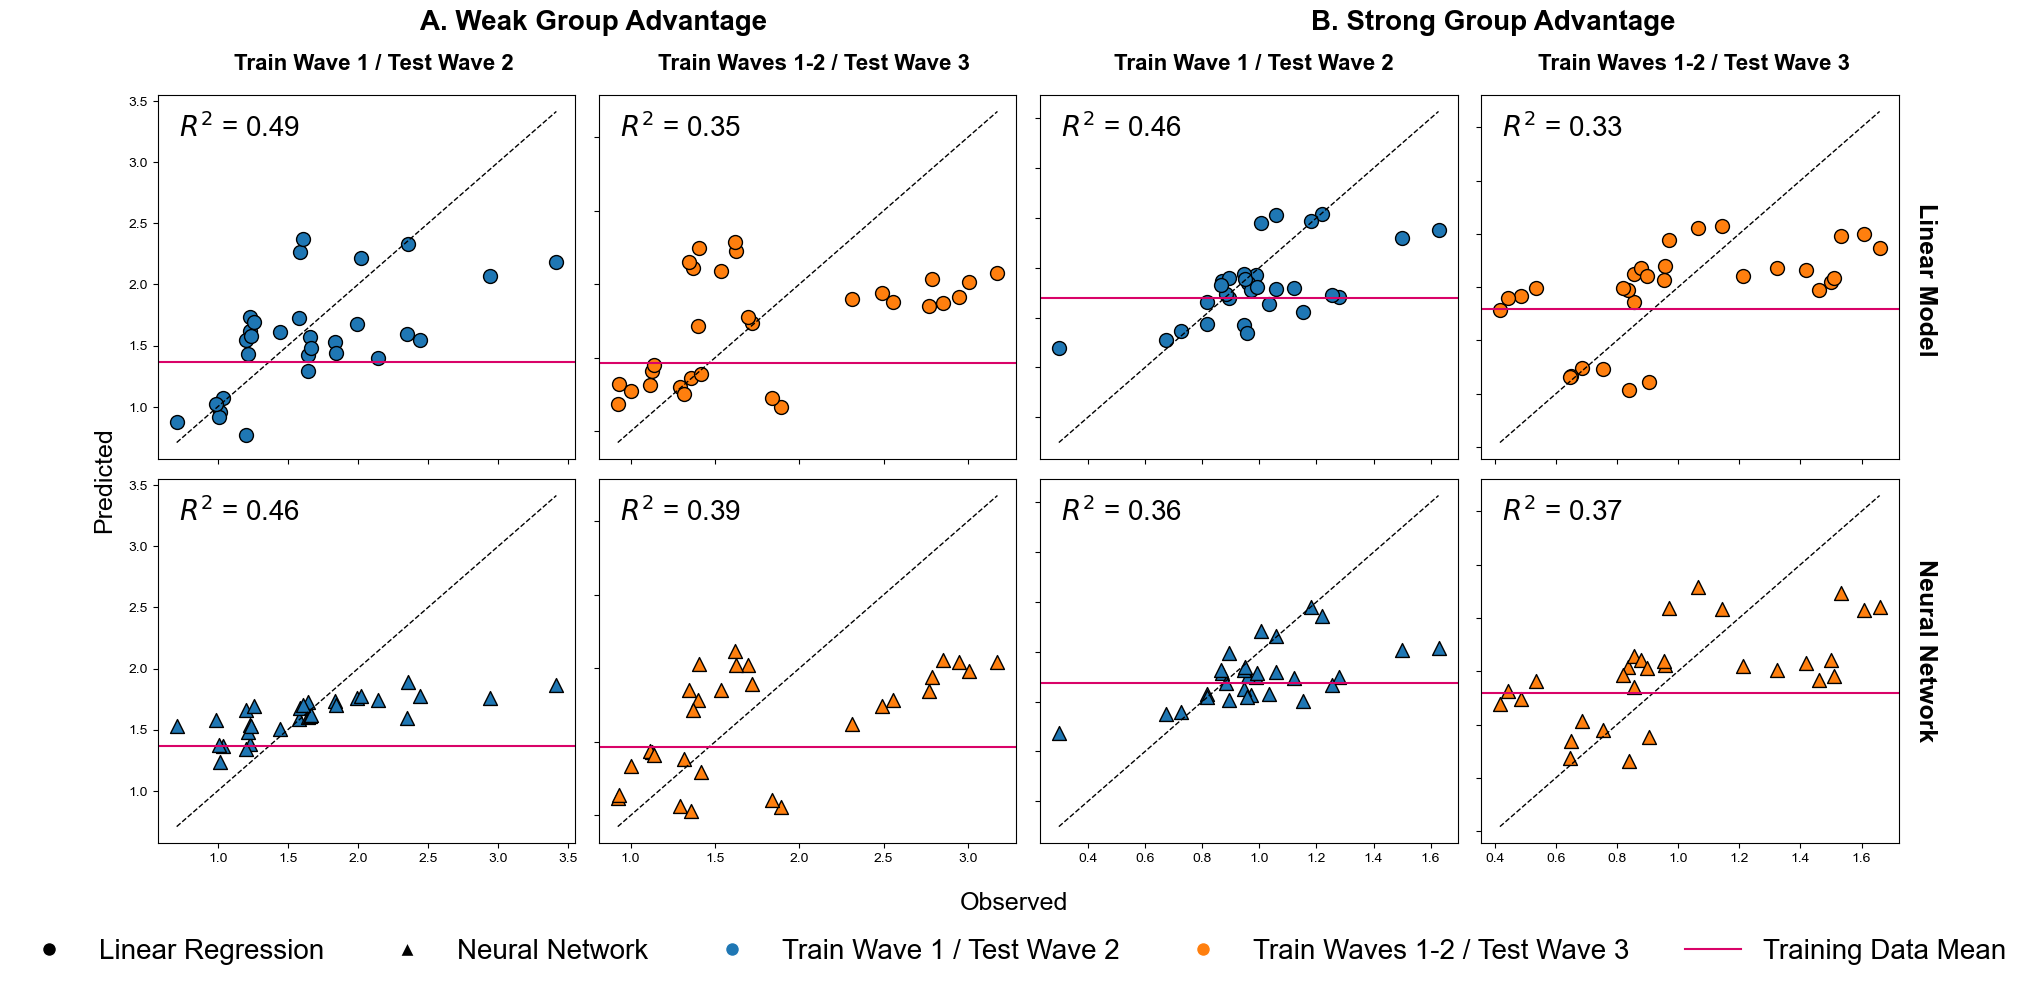

In [25]:
wave_data = [
    (wave1_df_condition_level_data, wave2_df_condition_level_data),
    (wave12_df_condition_level_data, wave3_df_condition_level_data)
]

plot_multiple_models(MODELS, wave_data, basic_IVs)

# R^2 p-value Comparisons

In [26]:
# get some code that bootstraps the dataset by resampling a dataset of the same size, WITH replacement
def resample_dataframe(df, seed = 19104):
	return df.sample(n=len(df), replace = True, random_state = seed)

# resample our main dataframes
NUM_SAMPLES = 1000
wave2_df_condition_resampled = [resample_dataframe(wave2_df_condition_level_data, i) for i in range(NUM_SAMPLES)]
wave3_df_condition_resampled = [resample_dataframe(wave3_df_condition_level_data, i) for i in range(NUM_SAMPLES)]

In [27]:
R2_resampled_results = {
    "Task Space LM": {
        "Strong (Train Wave 1, Predict Wave 2)": [],
        "Weak (Train Wave 1, Predict Wave 2)": [],
        "Strong (Train Waves 1-2, Predict Wave 3)": [],
        "Weak (Train Waves 1-2, Predict Wave 3)": []
    },
    "Task Space NN": {
        "Strong (Train Wave 1, Predict Wave 2)": [],
        "Weak (Train Wave 1, Predict Wave 2)": [],
        "Strong (Train Waves 1-2, Predict Wave 3)": [],
        "Weak (Train Waves 1-2, Predict Wave 3)": []
    },
}

for i in tqdm(range(NUM_SAMPLES)):
    set_random_seeds(seed_value=i) # set seed for reproducibility!
    
    for model_name in R2_resampled_results.keys():
        for model_key in MODELS[model_name].keys():
            # Grab the basic model information
            model = MODELS[model_name][model_key]
            dv = "strong" if "Strong" in model_key else "weak"
            wave_index = 0 if "Wave 1" in model_key else 1
            wave_a, wave_b = wave_data[wave_index]
            wave_b_resampled = wave2_df_condition_resampled[i] if wave_index == 0 else wave3_df_condition_resampled[i]
            
            X_test = wave_b_resampled[basic_IVs]
            
            if model_name == "Task Space LM":
                if 'const' in model.model.exog_names:
                    X_test = sm.add_constant(X_test)
            y_actual = wave_b_resampled[dv].values
            

            if model_name == "Task Space LM":
                y_pred = model.predict(X_test)
            elif model_name == "Task Space NN":
                y_pred = model.predict(X_test.values).flatten()

            r2 = custom_r2(y_pred, y_actual, wave_a, wave_b_resampled, dv)
            R2_resampled_results[model_name][model_key].append(r2)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 1/1000 [00:00<03:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 2/1000 [00:00<03:04,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 3/1000 [00:00<02:58,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 4/1000 [00:00<02:54,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 5/1000 [00:00<02:52,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 6/1000 [00:01<02:51,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 7/1000 [00:01<02:51,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 8/1000 [00:01<02:49,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 9/1000 [00:01<02:47,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 10/1000 [00:01<02:48,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 11/1000 [00:01<02:47,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 12/1000 [00:02<02:48,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 13/1000 [00:02<02:47,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 14/1000 [00:02<02:49,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 15/1000 [00:02<02:48,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 16/1000 [00:02<02:48,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 17/1000 [00:02<02:49,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 18/1000 [00:03<03:00,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 19/1000 [00:03<03:01,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 20/1000 [00:03<02:58,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 21/1000 [00:03<03:08,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 22/1000 [00:03<03:03,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 23/1000 [00:04<03:00,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 24/1000 [00:04<02:56,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▎         | 25/1000 [00:04<03:00,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 26/1000 [00:04<02:56,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 27/1000 [00:04<02:52,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 28/1000 [00:04<02:50,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 29/1000 [00:05<02:47,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 30/1000 [00:05<02:46,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 31/1000 [00:05<02:46,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 32/1000 [00:05<02:45,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  3%|▎         | 33/1000 [00:05<03:20,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 34/1000 [00:06<03:47,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▎         | 35/1000 [00:06<03:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▎         | 36/1000 [00:06<03:28,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▎         | 37/1000 [00:06<03:19,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 38/1000 [00:06<03:13,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 39/1000 [00:07<03:09,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 40/1000 [00:07<03:05,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 41/1000 [00:07<02:58,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 42/1000 [00:07<02:57,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 43/1000 [00:07<02:56,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 44/1000 [00:08<02:54,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 45/1000 [00:08<02:54,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 46/1000 [00:08<02:52,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 47/1000 [00:08<02:54,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 48/1000 [00:08<02:54,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 49/1000 [00:08<02:51,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 50/1000 [00:09<02:48,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 51/1000 [00:09<02:46,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 52/1000 [00:09<02:45,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 53/1000 [00:09<02:43,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  5%|▌         | 54/1000 [00:09<02:49,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 55/1000 [00:10<02:51,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 56/1000 [00:10<02:47,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 57/1000 [00:10<02:44,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 58/1000 [00:10<02:42,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 59/1000 [00:10<02:43,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 60/1000 [00:10<02:41,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 61/1000 [00:11<02:41,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 62/1000 [00:11<02:40,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 63/1000 [00:11<02:39,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▋         | 64/1000 [00:11<02:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▋         | 65/1000 [00:11<02:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 66/1000 [00:11<02:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 67/1000 [00:12<02:38,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 68/1000 [00:12<02:36,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 69/1000 [00:12<02:36,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 70/1000 [00:12<02:36,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 71/1000 [00:12<02:37,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 72/1000 [00:12<02:35,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 73/1000 [00:13<02:36,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 74/1000 [00:13<02:35,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 75/1000 [00:13<02:33,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 76/1000 [00:13<02:34,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 77/1000 [00:13<02:34,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 78/1000 [00:13<02:34,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 79/1000 [00:14<02:33,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 80/1000 [00:14<02:34,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 81/1000 [00:14<02:33,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 82/1000 [00:14<02:34,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 83/1000 [00:14<02:34,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 84/1000 [00:14<02:43,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 85/1000 [00:15<02:40,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▊         | 86/1000 [00:15<02:37,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 87/1000 [00:15<02:36,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 88/1000 [00:15<02:35,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 89/1000 [00:15<02:37,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 90/1000 [00:15<02:36,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 91/1000 [00:16<04:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 92/1000 [00:16<03:37,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 93/1000 [00:16<03:21,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 94/1000 [00:17<03:09,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 95/1000 [00:17<03:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 96/1000 [00:17<02:57,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 97/1000 [00:17<02:49,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 98/1000 [00:17<02:44,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 99/1000 [00:17<02:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 100/1000 [00:18<02:38,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|█         | 101/1000 [00:18<02:46,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█         | 102/1000 [00:18<02:57,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 103/1000 [00:18<02:52,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 104/1000 [00:18<02:47,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 105/1000 [00:19<02:45,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 106/1000 [00:19<03:03,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 107/1000 [00:19<03:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 108/1000 [00:19<02:56,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 109/1000 [00:19<02:50,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 110/1000 [00:20<02:44,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 111/1000 [00:20<02:42,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 112/1000 [00:20<02:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 113/1000 [00:20<02:37,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 114/1000 [00:20<02:34,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 115/1000 [00:20<02:34,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 116/1000 [00:21<02:32,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 117/1000 [00:21<02:30,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 118/1000 [00:21<02:30,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 119/1000 [00:21<02:30,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 12%|█▏        | 120/1000 [00:22<03:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 121/1000 [00:22<03:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 122/1000 [00:22<03:49,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 123/1000 [00:22<03:34,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 124/1000 [00:22<03:26,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▎        | 125/1000 [00:23<03:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 126/1000 [00:23<03:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 127/1000 [00:23<03:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 13%|█▎        | 128/1000 [00:24<03:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 129/1000 [00:24<04:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 130/1000 [00:24<03:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 131/1000 [00:24<03:36,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 132/1000 [00:24<03:25,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 133/1000 [00:25<03:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 134/1000 [00:25<03:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 135/1000 [00:25<02:51,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 136/1000 [00:25<02:45,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 137/1000 [00:25<02:40,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 138/1000 [00:26<02:35,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 139/1000 [00:26<02:35,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 140/1000 [00:26<02:34,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 141/1000 [00:26<02:31,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 142/1000 [00:26<02:29,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 143/1000 [00:26<02:29,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 144/1000 [00:27<02:29,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 145/1000 [00:27<02:28,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 146/1000 [00:27<02:26,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 147/1000 [00:27<02:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 148/1000 [00:27<02:25,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 149/1000 [00:27<02:30,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 150/1000 [00:28<02:28,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 151/1000 [00:28<02:26,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 152/1000 [00:28<02:25,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 153/1000 [00:28<02:24,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▌        | 154/1000 [00:28<02:36,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 155/1000 [00:29<02:35,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 156/1000 [00:29<02:31,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 157/1000 [00:29<02:30,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 158/1000 [00:29<02:28,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 159/1000 [00:29<02:26,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 160/1000 [00:29<02:26,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 161/1000 [00:30<02:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 162/1000 [00:30<02:26,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▋        | 163/1000 [00:30<02:30,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▋        | 164/1000 [00:30<02:32,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▋        | 165/1000 [00:30<03:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 166/1000 [00:31<03:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 167/1000 [00:31<02:56,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 168/1000 [00:31<02:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 169/1000 [00:31<02:48,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 170/1000 [00:31<02:41,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 171/1000 [00:32<02:36,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 172/1000 [00:32<02:33,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 173/1000 [00:32<02:35,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 174/1000 [00:32<02:35,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 175/1000 [00:32<02:31,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 176/1000 [00:32<02:28,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 177/1000 [00:33<03:24,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 178/1000 [00:33<03:19,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 179/1000 [00:33<03:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 180/1000 [00:34<02:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 181/1000 [00:34<02:50,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 182/1000 [00:34<02:46,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 183/1000 [00:34<02:43,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 184/1000 [00:34<02:43,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 185/1000 [00:34<02:38,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▊        | 186/1000 [00:35<02:34,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▊        | 187/1000 [00:35<02:33,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 188/1000 [00:35<02:30,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 189/1000 [00:35<02:26,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 190/1000 [00:35<02:24,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 191/1000 [00:36<02:21,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 192/1000 [00:36<02:20,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 193/1000 [00:36<02:25,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 194/1000 [00:36<02:31,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|█▉        | 195/1000 [00:36<02:33,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 196/1000 [00:36<02:29,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|█▉        | 197/1000 [00:37<02:29,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|█▉        | 198/1000 [00:37<02:28,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|█▉        | 199/1000 [00:37<02:25,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 200/1000 [00:37<02:26,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 201/1000 [00:37<02:26,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 202/1000 [00:38<02:24,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 203/1000 [00:38<02:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 204/1000 [00:38<02:24,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 205/1000 [00:38<02:34,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 206/1000 [00:38<02:50,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 207/1000 [00:39<02:39,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 208/1000 [00:39<02:33,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 209/1000 [00:39<02:29,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 210/1000 [00:39<02:27,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 211/1000 [00:39<02:24,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 212/1000 [00:39<02:24,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 213/1000 [00:40<02:21,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██▏       | 214/1000 [00:40<02:26,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 215/1000 [00:40<02:23,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 216/1000 [00:40<02:20,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 217/1000 [00:40<02:38,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 218/1000 [00:41<02:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 219/1000 [00:41<02:42,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 220/1000 [00:41<02:35,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 221/1000 [00:41<02:27,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 222/1000 [00:41<02:23,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 223/1000 [00:42<02:28,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 224/1000 [00:42<02:24,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▎       | 225/1000 [00:42<03:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 226/1000 [00:42<02:59,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 227/1000 [00:43<02:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 228/1000 [00:43<02:34,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 229/1000 [00:43<02:26,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 230/1000 [00:43<02:24,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 231/1000 [00:43<02:22,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 232/1000 [00:43<02:21,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 233/1000 [00:44<02:17,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 234/1000 [00:44<02:15,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 235/1000 [00:44<02:13,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 236/1000 [00:44<02:11,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 237/1000 [00:44<02:11,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 238/1000 [00:44<02:10,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 239/1000 [00:45<02:09,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 240/1000 [00:45<02:12,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 241/1000 [00:45<02:15,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 242/1000 [00:45<02:15,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 243/1000 [00:45<02:14,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 244/1000 [00:46<02:13,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 245/1000 [00:46<02:11,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 246/1000 [00:46<02:10,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 247/1000 [00:46<02:10,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 248/1000 [00:46<02:08,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▍       | 249/1000 [00:47<02:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 250/1000 [00:47<02:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 251/1000 [00:47<02:37,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 252/1000 [00:47<02:30,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 253/1000 [00:47<02:26,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 254/1000 [00:47<02:23,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 255/1000 [00:48<02:20,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 256/1000 [00:48<02:16,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 257/1000 [00:48<02:14,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 258/1000 [00:48<02:27,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 259/1000 [00:48<02:24,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 260/1000 [00:49<02:19,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 261/1000 [00:49<02:16,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 262/1000 [00:49<02:14,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▋       | 263/1000 [00:49<02:13,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▋       | 264/1000 [00:49<02:10,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 265/1000 [00:50<02:14,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 266/1000 [00:50<02:16,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 267/1000 [00:50<02:19,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 268/1000 [00:50<02:18,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 269/1000 [00:50<02:14,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 270/1000 [00:50<02:11,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 271/1000 [00:51<02:09,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 272/1000 [00:51<02:09,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 273/1000 [00:51<02:13,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 274/1000 [00:51<02:14,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 275/1000 [00:51<02:16,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 276/1000 [00:52<03:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 277/1000 [00:52<03:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 278/1000 [00:52<03:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 279/1000 [00:53<02:57,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 280/1000 [00:53<02:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 281/1000 [00:53<02:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 282/1000 [00:53<02:25,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 283/1000 [00:53<02:18,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 284/1000 [00:53<02:14,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 285/1000 [00:54<02:13,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 286/1000 [00:54<02:13,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 287/1000 [00:54<02:12,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 288/1000 [00:54<02:23,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 289/1000 [00:54<02:21,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 290/1000 [00:55<02:19,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 291/1000 [00:55<02:17,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 292/1000 [00:55<02:15,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 293/1000 [00:55<02:12,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 294/1000 [00:55<02:09,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██▉       | 295/1000 [00:56<02:10,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 296/1000 [00:56<02:09,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 297/1000 [00:56<02:08,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 298/1000 [00:56<02:08,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 299/1000 [00:56<02:08,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 300/1000 [00:56<02:06,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 301/1000 [00:57<02:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 302/1000 [00:57<02:03,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 303/1000 [00:57<02:01,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 304/1000 [00:57<02:04,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 305/1000 [00:57<02:04,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 306/1000 [00:58<02:02,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 307/1000 [00:58<02:01,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 308/1000 [00:58<01:59,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 309/1000 [00:58<02:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 310/1000 [00:58<02:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 311/1000 [00:58<02:04,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 312/1000 [00:59<02:05,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███▏      | 313/1000 [00:59<02:05,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███▏      | 314/1000 [00:59<02:03,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 315/1000 [00:59<02:00,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 316/1000 [00:59<02:03,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 317/1000 [01:00<02:05,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 318/1000 [01:00<02:05,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 319/1000 [01:00<02:04,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 320/1000 [01:00<02:02,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 321/1000 [01:00<02:01,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 322/1000 [01:00<02:01,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 323/1000 [01:01<01:58,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 324/1000 [01:01<01:56,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 32%|███▎      | 325/1000 [01:01<02:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 326/1000 [01:01<02:50,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 327/1000 [01:02<02:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 328/1000 [01:02<02:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 329/1000 [01:02<02:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 330/1000 [01:02<02:16,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 331/1000 [01:02<02:19,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 332/1000 [01:03<02:15,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 333/1000 [01:03<02:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 334/1000 [01:03<02:09,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 335/1000 [01:03<02:06,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▎      | 336/1000 [01:03<02:03,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 337/1000 [01:03<02:04,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 338/1000 [01:04<02:02,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 339/1000 [01:04<01:59,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 340/1000 [01:04<01:57,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 341/1000 [01:04<01:55,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 342/1000 [01:04<01:53,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 343/1000 [01:05<01:56,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 344/1000 [01:05<01:57,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 345/1000 [01:05<01:57,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▍      | 346/1000 [01:05<01:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 347/1000 [01:05<01:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 348/1000 [01:05<01:57,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 349/1000 [01:06<02:00,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 350/1000 [01:06<02:00,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 351/1000 [01:06<01:58,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 352/1000 [01:06<01:56,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 353/1000 [01:06<01:56,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 354/1000 [01:07<01:56,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 355/1000 [01:07<01:57,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 356/1000 [01:07<01:57,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▌      | 357/1000 [01:07<02:08,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 358/1000 [01:07<02:11,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 359/1000 [01:08<02:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 360/1000 [01:08<02:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 361/1000 [01:08<02:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 362/1000 [01:08<02:13,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 363/1000 [01:08<02:07,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 364/1000 [01:09<02:02,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 365/1000 [01:09<01:59,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 366/1000 [01:09<02:09,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 367/1000 [01:09<02:03,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 368/1000 [01:09<01:59,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 369/1000 [01:10<01:57,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 370/1000 [01:10<01:55,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 371/1000 [01:10<01:53,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 372/1000 [01:10<01:52,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 37%|███▋      | 373/1000 [01:11<03:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 374/1000 [01:11<02:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 375/1000 [01:11<02:33,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 376/1000 [01:11<02:21,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 377/1000 [01:11<02:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 378/1000 [01:12<02:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 379/1000 [01:12<02:08,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 380/1000 [01:12<02:05,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 381/1000 [01:12<02:02,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 382/1000 [01:12<01:59,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 383/1000 [01:13<01:59,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 384/1000 [01:13<02:00,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 385/1000 [01:13<01:56,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▊      | 386/1000 [01:13<01:53,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 387/1000 [01:13<01:54,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 388/1000 [01:14<01:55,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 389/1000 [01:14<01:58,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 390/1000 [01:14<01:57,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 391/1000 [01:14<02:01,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 392/1000 [01:14<01:58,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 393/1000 [01:15<01:56,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 394/1000 [01:15<01:56,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 395/1000 [01:15<01:56,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███▉      | 396/1000 [01:15<01:54,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 397/1000 [01:15<01:52,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 398/1000 [01:15<01:51,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 399/1000 [01:16<01:50,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 400/1000 [01:16<01:49,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 401/1000 [01:16<01:49,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 402/1000 [01:16<01:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 403/1000 [01:16<01:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 404/1000 [01:17<01:47,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 405/1000 [01:17<01:48,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 406/1000 [01:17<01:47,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 407/1000 [01:17<01:46,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 408/1000 [01:17<01:45,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 409/1000 [01:17<01:45,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 410/1000 [01:18<01:44,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 411/1000 [01:18<01:44,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 412/1000 [01:18<01:44,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 413/1000 [01:18<01:44,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 414/1000 [01:18<01:44,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 415/1000 [01:19<01:43,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 416/1000 [01:19<01:43,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 417/1000 [01:19<01:42,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 418/1000 [01:19<01:43,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 419/1000 [01:19<01:43,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 420/1000 [01:19<01:42,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 421/1000 [01:20<01:42,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 422/1000 [01:20<02:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 423/1000 [01:20<02:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 424/1000 [01:20<02:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▎     | 425/1000 [01:21<01:55,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 426/1000 [01:21<01:51,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 427/1000 [01:21<01:48,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 428/1000 [01:21<01:46,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 43%|████▎     | 429/1000 [01:22<02:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 430/1000 [01:22<02:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 431/1000 [01:22<02:22,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 432/1000 [01:22<02:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 433/1000 [01:22<02:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 434/1000 [01:23<01:56,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 435/1000 [01:23<01:51,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▎     | 436/1000 [01:23<01:48,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 437/1000 [01:23<01:46,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 438/1000 [01:23<01:44,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 439/1000 [01:23<01:43,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 440/1000 [01:24<01:42,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 441/1000 [01:24<01:40,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 442/1000 [01:24<01:40,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 443/1000 [01:24<01:40,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 444/1000 [01:24<01:39,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 445/1000 [01:25<01:39,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 446/1000 [01:25<01:40,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▍     | 447/1000 [01:25<01:39,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▍     | 448/1000 [01:25<01:38,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▍     | 449/1000 [01:25<01:37,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 450/1000 [01:25<01:37,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 451/1000 [01:26<01:36,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 452/1000 [01:26<01:36,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 453/1000 [01:26<01:37,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 454/1000 [01:26<01:37,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 455/1000 [01:26<01:36,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 456/1000 [01:26<01:36,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 457/1000 [01:27<01:35,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 458/1000 [01:27<01:35,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 459/1000 [01:27<01:35,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 460/1000 [01:27<01:35,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 461/1000 [01:27<01:35,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 462/1000 [01:28<01:35,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▋     | 463/1000 [01:28<01:35,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▋     | 464/1000 [01:28<01:35,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▋     | 465/1000 [01:28<01:35,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 466/1000 [01:28<01:57,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 467/1000 [01:29<01:56,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 468/1000 [01:29<01:54,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 469/1000 [01:29<01:47,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 470/1000 [01:29<01:43,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 471/1000 [01:29<01:39,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 472/1000 [01:30<01:37,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 473/1000 [01:30<01:35,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 474/1000 [01:30<01:34,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 475/1000 [01:30<01:34,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 476/1000 [01:30<01:34,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 477/1000 [01:30<01:33,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 478/1000 [01:31<01:32,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 479/1000 [01:31<01:32,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 480/1000 [01:31<01:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 481/1000 [01:31<01:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 482/1000 [01:31<01:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 483/1000 [01:31<01:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 484/1000 [01:32<01:30,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 485/1000 [01:32<01:30,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▊     | 486/1000 [01:32<01:31,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▊     | 487/1000 [01:32<01:32,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 488/1000 [01:32<01:33,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 489/1000 [01:33<01:33,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 490/1000 [01:33<01:31,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 491/1000 [01:33<01:30,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 492/1000 [01:33<01:30,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 493/1000 [01:33<01:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 494/1000 [01:33<01:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████▉     | 495/1000 [01:34<01:28,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 496/1000 [01:34<01:28,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 497/1000 [01:34<01:28,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████▉     | 498/1000 [01:34<01:28,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 499/1000 [01:34<01:27,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 500/1000 [01:34<01:27,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 501/1000 [01:35<01:27,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 502/1000 [01:35<01:27,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 503/1000 [01:35<01:27,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 504/1000 [01:35<01:27,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 505/1000 [01:35<01:26,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 506/1000 [01:36<01:26,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████     | 507/1000 [01:36<01:26,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 508/1000 [01:36<01:25,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 509/1000 [01:36<01:26,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 510/1000 [01:36<01:26,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 511/1000 [01:36<01:25,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 512/1000 [01:37<01:45,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████▏    | 513/1000 [01:37<01:41,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████▏    | 514/1000 [01:37<01:36,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 515/1000 [01:37<01:33,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 516/1000 [01:37<01:30,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 517/1000 [01:38<01:28,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 518/1000 [01:38<01:27,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 519/1000 [01:38<01:26,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 520/1000 [01:38<01:25,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 521/1000 [01:38<01:25,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 522/1000 [01:38<01:24,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 523/1000 [01:39<01:24,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 524/1000 [01:39<01:24,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▎    | 525/1000 [01:39<01:23,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 526/1000 [01:39<01:22,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 527/1000 [01:39<01:23,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 528/1000 [01:40<01:23,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 529/1000 [01:40<01:22,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 530/1000 [01:40<01:22,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 531/1000 [01:40<01:22,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 532/1000 [01:40<01:22,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 533/1000 [01:40<01:22,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 534/1000 [01:41<01:23,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▎    | 535/1000 [01:41<01:22,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▎    | 536/1000 [01:41<01:21,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▎    | 537/1000 [01:41<01:21,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 538/1000 [01:41<01:21,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 539/1000 [01:41<01:21,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 540/1000 [01:42<01:20,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 541/1000 [01:42<01:20,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 542/1000 [01:42<01:20,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 543/1000 [01:42<01:20,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 544/1000 [01:42<01:20,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 545/1000 [01:43<01:20,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 546/1000 [01:43<01:19,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 547/1000 [01:43<01:19,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 548/1000 [01:43<01:18,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 549/1000 [01:43<01:18,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 550/1000 [01:43<01:18,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 551/1000 [01:44<01:18,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 552/1000 [01:44<01:18,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 553/1000 [01:44<01:17,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 554/1000 [01:44<01:17,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 555/1000 [01:44<01:17,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 556/1000 [01:45<01:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 557/1000 [01:45<01:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 558/1000 [01:45<01:28,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 559/1000 [01:45<01:25,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 560/1000 [01:45<01:23,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 561/1000 [01:46<01:21,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 562/1000 [01:46<01:19,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 563/1000 [01:46<01:18,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 564/1000 [01:46<01:17,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 565/1000 [01:46<01:22,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 566/1000 [01:46<01:20,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 567/1000 [01:47<01:21,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 568/1000 [01:47<01:19,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 569/1000 [01:47<01:18,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 570/1000 [01:47<01:16,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 571/1000 [01:47<01:16,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 572/1000 [01:47<01:15,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 573/1000 [01:48<01:14,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 574/1000 [01:48<01:13,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▊    | 575/1000 [01:48<01:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 576/1000 [01:48<01:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 577/1000 [01:48<01:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 578/1000 [01:49<01:14,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 579/1000 [01:49<01:13,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 580/1000 [01:49<01:13,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 581/1000 [01:49<01:13,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 582/1000 [01:49<01:12,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 583/1000 [01:49<01:12,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 584/1000 [01:50<01:12,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 585/1000 [01:50<01:11,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▊    | 586/1000 [01:50<01:11,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 587/1000 [01:50<01:11,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 588/1000 [01:50<01:10,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 589/1000 [01:50<01:10,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 590/1000 [01:51<01:13,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 591/1000 [01:51<01:13,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 592/1000 [01:51<01:12,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 593/1000 [01:51<01:12,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 594/1000 [01:51<01:11,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 595/1000 [01:51<01:11,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 596/1000 [01:52<01:10,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 597/1000 [01:52<01:10,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 598/1000 [01:52<01:11,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 599/1000 [01:52<01:43,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 600/1000 [01:53<01:34,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 601/1000 [01:53<01:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 602/1000 [01:53<01:21,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 603/1000 [01:53<01:17,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 604/1000 [01:53<01:15,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 605/1000 [01:54<01:13,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 606/1000 [01:54<01:11,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 607/1000 [01:54<01:10,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 608/1000 [01:54<01:09,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 609/1000 [01:54<01:09,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 610/1000 [01:54<01:08,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 611/1000 [01:55<01:08,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 612/1000 [01:55<01:08,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 613/1000 [01:55<01:08,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 614/1000 [01:55<01:08,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 615/1000 [01:55<01:07,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 616/1000 [01:55<01:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 617/1000 [01:56<01:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 618/1000 [01:56<01:06,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 619/1000 [01:56<01:06,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 620/1000 [01:56<01:06,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 621/1000 [01:56<01:05,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 622/1000 [01:57<01:05,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 623/1000 [01:57<01:06,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 624/1000 [01:57<01:05,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▎   | 625/1000 [01:57<01:05,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 626/1000 [01:57<01:05,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 627/1000 [01:57<01:04,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 628/1000 [01:58<01:03,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 629/1000 [01:58<01:04,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 630/1000 [01:58<01:04,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 631/1000 [01:58<01:03,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 632/1000 [01:58<01:03,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 633/1000 [01:58<01:03,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 634/1000 [01:59<01:03,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 635/1000 [01:59<01:03,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 636/1000 [01:59<01:03,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 637/1000 [01:59<01:03,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 638/1000 [01:59<01:03,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 639/1000 [01:59<01:02,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 640/1000 [02:00<01:02,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 641/1000 [02:00<01:16,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 642/1000 [02:00<01:14,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 643/1000 [02:00<01:12,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 644/1000 [02:00<01:09,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 645/1000 [02:01<01:06,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 646/1000 [02:01<01:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 647/1000 [02:01<01:04,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 648/1000 [02:01<01:03,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 649/1000 [02:01<01:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 650/1000 [02:02<01:02,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 651/1000 [02:02<01:01,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 652/1000 [02:02<01:01,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 653/1000 [02:02<01:00,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 654/1000 [02:02<01:00,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 655/1000 [02:02<01:00,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 656/1000 [02:03<01:00,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 657/1000 [02:03<00:59,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 658/1000 [02:03<00:59,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 659/1000 [02:03<00:59,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 660/1000 [02:03<00:59,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 661/1000 [02:03<00:58,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 662/1000 [02:04<00:58,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 663/1000 [02:04<00:58,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 664/1000 [02:04<00:58,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 665/1000 [02:04<00:58,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 666/1000 [02:04<00:57,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 667/1000 [02:04<00:57,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 668/1000 [02:05<00:57,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 669/1000 [02:05<00:57,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 670/1000 [02:05<00:56,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 671/1000 [02:05<00:56,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 672/1000 [02:05<00:56,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 673/1000 [02:06<00:56,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 674/1000 [02:06<00:56,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 675/1000 [02:06<00:55,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 676/1000 [02:06<00:55,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 677/1000 [02:06<00:56,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 678/1000 [02:06<00:55,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 679/1000 [02:07<00:55,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 680/1000 [02:07<00:55,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 681/1000 [02:07<01:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 682/1000 [02:07<01:07,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 683/1000 [02:07<01:03,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 684/1000 [02:08<01:00,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 685/1000 [02:08<00:58,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▊   | 686/1000 [02:08<00:57,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 687/1000 [02:08<00:56,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 688/1000 [02:08<00:55,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 689/1000 [02:08<00:55,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 690/1000 [02:09<00:54,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 691/1000 [02:09<00:53,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 692/1000 [02:09<00:54,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 693/1000 [02:09<00:54,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 694/1000 [02:09<00:53,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████▉   | 695/1000 [02:10<00:53,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 696/1000 [02:10<00:52,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 697/1000 [02:10<00:52,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 698/1000 [02:10<00:52,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 699/1000 [02:10<00:51,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 700/1000 [02:10<00:54,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 701/1000 [02:11<00:53,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 702/1000 [02:11<00:52,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 703/1000 [02:11<00:51,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 704/1000 [02:11<00:51,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 705/1000 [02:11<00:51,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 706/1000 [02:11<00:50,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 707/1000 [02:12<00:50,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 708/1000 [02:12<00:50,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 709/1000 [02:12<00:50,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 710/1000 [02:12<00:50,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 711/1000 [02:12<00:49,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 712/1000 [02:12<00:49,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 713/1000 [02:13<00:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████▏  | 714/1000 [02:13<00:49,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 715/1000 [02:13<00:48,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 716/1000 [02:13<00:49,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 717/1000 [02:13<00:48,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 718/1000 [02:13<00:48,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 719/1000 [02:14<00:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 720/1000 [02:14<00:47,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 721/1000 [02:14<01:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 722/1000 [02:14<00:58,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 723/1000 [02:15<00:55,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 724/1000 [02:15<00:52,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▎  | 725/1000 [02:15<00:51,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 726/1000 [02:15<00:50,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 727/1000 [02:15<00:48,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 728/1000 [02:15<00:48,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 729/1000 [02:16<00:47,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 730/1000 [02:16<00:46,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 731/1000 [02:16<00:46,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 732/1000 [02:16<00:46,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 733/1000 [02:16<00:45,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 734/1000 [02:16<00:45,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▎  | 735/1000 [02:17<00:47,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 736/1000 [02:17<00:46,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▎  | 737/1000 [02:17<00:46,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 738/1000 [02:17<00:46,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 739/1000 [02:17<00:45,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 740/1000 [02:17<00:45,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 741/1000 [02:18<00:44,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 742/1000 [02:18<00:47,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 743/1000 [02:18<00:46,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 744/1000 [02:18<00:45,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 745/1000 [02:18<00:44,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 746/1000 [02:19<00:44,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 747/1000 [02:19<00:43,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 748/1000 [02:19<00:43,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 749/1000 [02:19<00:42,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 750/1000 [02:19<00:43,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 751/1000 [02:19<00:42,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 752/1000 [02:20<00:42,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 753/1000 [02:20<00:42,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 754/1000 [02:20<00:42,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 755/1000 [02:20<00:42,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 756/1000 [02:20<00:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 757/1000 [02:20<00:41,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 758/1000 [02:21<00:58,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 759/1000 [02:21<00:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 760/1000 [02:21<00:49,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 761/1000 [02:22<01:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 762/1000 [02:22<01:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▋  | 763/1000 [02:22<00:56,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▋  | 764/1000 [02:22<00:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▋  | 765/1000 [02:22<00:48,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 766/1000 [02:23<00:45,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 77%|███████▋  | 767/1000 [02:23<00:46,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 768/1000 [02:23<00:45,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 769/1000 [02:23<00:44,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 770/1000 [02:23<00:44,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 771/1000 [02:24<00:43,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 772/1000 [02:24<00:41,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 773/1000 [02:24<00:40,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 774/1000 [02:24<00:42,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 775/1000 [02:24<00:47,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 776/1000 [02:25<00:44,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 777/1000 [02:25<00:42,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 778/1000 [02:25<00:41,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 779/1000 [02:25<00:40,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 780/1000 [02:25<00:39,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 781/1000 [02:25<00:39,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 782/1000 [02:26<00:38,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 783/1000 [02:26<00:38,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 784/1000 [02:26<00:37,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 785/1000 [02:26<00:37,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▊  | 786/1000 [02:26<00:36,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▊  | 787/1000 [02:26<00:36,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 788/1000 [02:27<00:36,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 789/1000 [02:27<00:36,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 790/1000 [02:27<00:35,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 791/1000 [02:27<00:35,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 792/1000 [02:27<00:35,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 793/1000 [02:27<00:35,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 794/1000 [02:28<00:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 795/1000 [02:28<00:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 796/1000 [02:28<00:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 797/1000 [02:28<00:41,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 798/1000 [02:29<00:38,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 799/1000 [02:29<00:37,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 800/1000 [02:29<00:36,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 801/1000 [02:29<00:35,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 802/1000 [02:29<00:34,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 803/1000 [02:29<00:34,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 804/1000 [02:30<00:34,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 805/1000 [02:30<00:33,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 806/1000 [02:30<00:33,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 807/1000 [02:30<00:33,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 808/1000 [02:30<00:32,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 809/1000 [02:30<00:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 810/1000 [02:31<00:32,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 811/1000 [02:31<00:32,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 812/1000 [02:31<00:32,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 813/1000 [02:31<00:31,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 814/1000 [02:31<00:31,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 815/1000 [02:32<00:31,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 816/1000 [02:32<00:31,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 817/1000 [02:32<00:31,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 818/1000 [02:32<00:31,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 819/1000 [02:32<00:30,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 820/1000 [02:32<00:30,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 821/1000 [02:33<00:30,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 822/1000 [02:33<00:30,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 823/1000 [02:33<00:30,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 824/1000 [02:33<00:30,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▎ | 825/1000 [02:33<00:29,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 826/1000 [02:33<00:29,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 827/1000 [02:34<00:29,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 828/1000 [02:34<00:29,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 829/1000 [02:34<00:29,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 830/1000 [02:34<00:29,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 831/1000 [02:34<00:28,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 832/1000 [02:34<00:28,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 833/1000 [02:35<00:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 834/1000 [02:35<00:33,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 835/1000 [02:35<00:31,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 836/1000 [02:35<00:32,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 837/1000 [02:35<00:30,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 838/1000 [02:36<00:29,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 839/1000 [02:36<00:29,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 840/1000 [02:36<00:28,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 841/1000 [02:36<00:28,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 842/1000 [02:36<00:27,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 843/1000 [02:36<00:27,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 844/1000 [02:37<00:26,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 845/1000 [02:37<00:26,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 846/1000 [02:37<00:26,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 847/1000 [02:37<00:26,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 848/1000 [02:37<00:25,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 849/1000 [02:37<00:25,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 850/1000 [02:38<00:25,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 851/1000 [02:38<00:25,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 852/1000 [02:38<00:25,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 853/1000 [02:38<00:25,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 854/1000 [02:38<00:25,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 855/1000 [02:39<00:24,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 856/1000 [02:39<00:24,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 857/1000 [02:39<00:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 858/1000 [02:39<00:24,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 859/1000 [02:39<00:24,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 860/1000 [02:39<00:23,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 861/1000 [02:40<00:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 862/1000 [02:40<00:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 863/1000 [02:40<00:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 864/1000 [02:40<00:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 865/1000 [02:40<00:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 866/1000 [02:40<00:23,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 87%|████████▋ | 867/1000 [02:41<00:33,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 868/1000 [02:41<00:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 869/1000 [02:41<00:27,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 870/1000 [02:41<00:25,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 871/1000 [02:42<00:24,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 872/1000 [02:42<00:23,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 873/1000 [02:42<00:23,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 874/1000 [02:42<00:22,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 875/1000 [02:42<00:22,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 876/1000 [02:42<00:21,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 877/1000 [02:43<00:21,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 878/1000 [02:43<00:21,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 879/1000 [02:43<00:20,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 880/1000 [02:43<00:20,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 881/1000 [02:43<00:20,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 882/1000 [02:43<00:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 883/1000 [02:44<00:20,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 884/1000 [02:44<00:20,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 885/1000 [02:44<00:20,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 886/1000 [02:44<00:20,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 887/1000 [02:44<00:19,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 888/1000 [02:44<00:19,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 889/1000 [02:45<00:19,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 890/1000 [02:45<00:18,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 891/1000 [02:45<00:18,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 892/1000 [02:45<00:18,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 893/1000 [02:45<00:18,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 894/1000 [02:46<00:18,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 895/1000 [02:46<00:17,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 896/1000 [02:46<00:17,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 897/1000 [02:46<00:17,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 898/1000 [02:46<00:17,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 899/1000 [02:46<00:17,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 900/1000 [02:47<00:17,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 901/1000 [02:47<00:17,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 902/1000 [02:47<00:17,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 903/1000 [02:47<00:16,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|█████████ | 904/1000 [02:47<00:21,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 905/1000 [02:48<00:20,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 906/1000 [02:48<00:18,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 907/1000 [02:48<00:18,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 908/1000 [02:48<00:17,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 909/1000 [02:48<00:17,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 910/1000 [02:48<00:16,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 911/1000 [02:49<00:15,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 912/1000 [02:49<00:15,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████▏| 913/1000 [02:49<00:15,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 914/1000 [02:49<00:15,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 915/1000 [02:49<00:14,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 916/1000 [02:50<00:14,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 917/1000 [02:50<00:14,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 918/1000 [02:50<00:14,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 919/1000 [02:50<00:14,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 920/1000 [02:50<00:13,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 921/1000 [02:50<00:13,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 922/1000 [02:51<00:13,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 923/1000 [02:51<00:13,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 924/1000 [02:51<00:13,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▎| 925/1000 [02:51<00:12,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 926/1000 [02:51<00:12,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 927/1000 [02:51<00:12,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 928/1000 [02:52<00:12,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 929/1000 [02:52<00:12,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 930/1000 [02:52<00:12,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 931/1000 [02:52<00:11,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 932/1000 [02:52<00:11,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 933/1000 [02:52<00:11,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 934/1000 [02:53<00:11,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 935/1000 [02:53<00:11,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 936/1000 [02:53<00:10,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 937/1000 [02:53<00:10,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 938/1000 [02:53<00:10,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 939/1000 [02:53<00:10,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 940/1000 [02:54<00:10,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 941/1000 [02:54<00:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 942/1000 [02:54<00:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 943/1000 [02:54<00:11,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 944/1000 [02:55<00:10,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 945/1000 [02:55<00:10,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 946/1000 [02:55<00:09,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 947/1000 [02:55<00:09,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 948/1000 [02:55<00:09,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 949/1000 [02:55<00:08,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 950/1000 [02:56<00:08,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 951/1000 [02:56<00:08,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 952/1000 [02:56<00:08,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 953/1000 [02:56<00:08,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 954/1000 [02:56<00:07,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 955/1000 [02:56<00:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 956/1000 [02:57<00:07,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 957/1000 [02:57<00:07,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 958/1000 [02:57<00:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 959/1000 [02:57<00:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 960/1000 [02:57<00:06,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 961/1000 [02:57<00:06,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 962/1000 [02:58<00:09,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▋| 963/1000 [02:58<00:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 964/1000 [02:58<00:07,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 965/1000 [02:58<00:07,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 966/1000 [02:59<00:06,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 967/1000 [02:59<00:06,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 968/1000 [02:59<00:05,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 969/1000 [02:59<00:05,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 970/1000 [02:59<00:05,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 971/1000 [02:59<00:05,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 972/1000 [03:00<00:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 973/1000 [03:00<00:04,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 974/1000 [03:00<00:04,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 975/1000 [03:00<00:04,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 976/1000 [03:01<00:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 977/1000 [03:01<00:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 978/1000 [03:01<00:04,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 979/1000 [03:01<00:03,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 980/1000 [03:01<00:03,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 981/1000 [03:01<00:03,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 982/1000 [03:02<00:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 983/1000 [03:02<00:03,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 984/1000 [03:02<00:02,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 985/1000 [03:02<00:02,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▊| 986/1000 [03:02<00:02,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▊| 987/1000 [03:02<00:02,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 988/1000 [03:03<00:02,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 989/1000 [03:03<00:01,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 990/1000 [03:03<00:01,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 991/1000 [03:03<00:01,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 992/1000 [03:03<00:01,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 993/1000 [03:03<00:01,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 994/1000 [03:04<00:01,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 995/1000 [03:04<00:00,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 996/1000 [03:04<00:00,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 997/1000 [03:04<00:00,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 998/1000 [03:04<00:00,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 999/1000 [03:05<00:00,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 1000/1000 [03:05<00:00,  5.40it/s]


In [28]:
def format_value(value):
    if value > 5 or value < -5:
        return np.format_float_scientific(value, precision=4)
    else:
        return np.round(value, 4)

def calculate_summary_stats(data):
    mean_val = np.mean(data)
    mean_val_formatted = format_value(mean_val)
    std_error = stats.sem(data)
    ci_lower = mean_val - 1.96 * std_error
    ci_upper = mean_val + 1.96 * std_error
    ci_lower_formatted = format_value(ci_lower)
    ci_upper_formatted = format_value(ci_upper)
    return mean_val_formatted, (ci_lower_formatted, ci_upper_formatted)

def format_p_value(p_value):
    if p_value < 0.001:
        return np.format_float_scientific(p_value, precision=4)
    else:
        return np.round(p_value, 4)

layer_2_keys = list(R2_resampled_results["Task Space LM"].keys())
results_df = pd.DataFrame(index=["Task Space LM", "Task Space NN"], columns=layer_2_keys)

p_values = []
comparisons = []

for key in layer_2_keys:
    results_lm = np.array(R2_resampled_results["Task Space LM"][key])
    results_nn = np.array(R2_resampled_results["Task Space NN"][key])
    
    stats_lm = calculate_summary_stats(results_lm)
    stats_nn = calculate_summary_stats(results_nn)

    results_df.at["Task Space LM", key] = stats_lm
    results_df.at["Task Space NN", key] = stats_nn
    
    differences = results_nn - results_lm
    t_statistic, p_value = stats.ttest_1samp(differences, 0)
    p_values.append(p_value)
    comparisons.append((key, "Task Space LM", "Task Space NN"))
    
    print(f"********Results for Comparison: {key}********")
    print(f"Task Space LM - Mean: {stats_lm[0]}, 95% CI: {stats_lm[1]}")
    print(f"Task Space NN - Mean: {stats_nn[0]}, 95% CI: {stats_nn[1]}")
    
    print(f"T-statistic (Task Space NN v. Task Space LM): {np.round(t_statistic, 4)}")
    print(f"P-value before correction: {np.format_float_scientific(p_value, precision=4)}")
    print("--------")

reject, pvals_corrected, _, _ = multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

print("********Corrected P-values********")
for index, (key, model_1, model_2) in enumerate(comparisons):
    corrected_p_value = format_p_value(pvals_corrected[index])
    print(f"Comparison ({model_1} v. {model_2}): {key} - Corrected P-value: {corrected_p_value}")

********Results for Comparison: Strong (Train Wave 1, Predict Wave 2)********
Task Space LM - Mean: 0.4438, 95% CI: (0.4373, 0.4503)
Task Space NN - Mean: 0.3489, 95% CI: (0.3441, 0.3537)
T-statistic (Task Space NN v. Task Space LM): -50.1381
P-value before correction: 5.0319e-275
--------
********Results for Comparison: Weak (Train Wave 1, Predict Wave 2)********
Task Space LM - Mean: 0.4574, 95% CI: (0.4486, 0.4662)
Task Space NN - Mean: 0.4569, 95% CI: (0.452, 0.4618)
T-statistic (Task Space NN v. Task Space LM): -0.1103
P-value before correction: 9.1222e-01
--------
********Results for Comparison: Strong (Train Waves 1-2, Predict Wave 3)********
Task Space LM - Mean: 0.3081, 95% CI: (0.3019, 0.3144)
Task Space NN - Mean: 0.3578, 95% CI: (0.3515, 0.3641)
T-statistic (Task Space NN v. Task Space LM): 38.4092
P-value before correction: 5.8915e-199
--------
********Results for Comparison: Weak (Train Waves 1-2, Predict Wave 3)********
Task Space LM - Mean: 0.3207, 95% CI: (0.3125, 0.32

# Permutation and SHAP

Note: main text is not clear about which model(s) we're doing the SHAP analysis for...

In [29]:
# Define Task Space Groups
pretty_feature_cluster_names = {
	"['Type 2 (Generate)', 'Creativity Input']": "Creative",
	"['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']": "Demonstrably Correct Answer",
	"['Conceptual-Behavioral', 'Intellectual-Manipulative']": "Physical",
	"Type 1 (Planning)": "Type 1 (Planning)",
	"Type 5 (Cognitive Conflict)": "Type 5 (Cognitive Conflict)",
	"Type 6 (Mixed-Motive)": "Type 6 (Mixed-Motive)",
	"Type 7 (Battle)": "Type 7 (Battle)",
	"Type 8 (Performance)": "Type 8 (Performance)",
	"Divisible-Unitary": "Divisible-Unitary",
	"Maximizing": "Maximizing",
	"Optimizing": "Optimizing",
	"Outcome Multiplicity": "Outcome Multiplicity",
	"Solution Scheme Multiplicity": "Solution Scheme Multiplicity",
	"Conflicting Tradeoffs": "Conflicting Tradeoffs",
	"Solution Scheme Outcome Uncertainty": "Solution Scheme Outcome Uncertainty",
	"Eureka Question": "Eureka Question"
}

Show relationships between clusters

In [30]:
df_condition_level_data[['Type 2 (Generate)', 'Creativity Input']].corr()

,Type 2 (Generate),Creativity Input
Type 2 (Generate),1.000000,0.829328
Creativity Input,0.829328,1.000000


In [31]:
df_condition_level_data[['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']].corr()

,Type 3 and Type 4 (Objective Correctness),Decision Verifiability,Shared Knowledge,Within-System Solution,Answer Recognizability,Time Solvability,Intellective-Judgmental
Type 3 and Type 4 (Objective Correctness),1.000000,0.967066,0.928585,0.654567,0.959369,0.975959,0.982612
Decision Verifiability,0.967066,1.000000,0.908816,0.682047,0.972943,0.973843,0.945500
Shared Knowledge,0.928585,0.908816,1.000000,0.611842,0.915565,0.933360,0.961674
Within-System Solution,0.654567,0.682047,0.611842,1.000000,0.721279,0.698743,0.598344
Answer Recognizability,0.959369,0.972943,0.915565,0.721279,1.000000,0.962793,0.946780
Time Solvability,0.975959,0.973843,0.933360,0.698743,0.962793,1.000000,0.959235
Intellective-Judgmental,0.982612,0.945500,0.961674,0.598344,0.946780,0.959235,1.000000


In [32]:
df_condition_level_data[['Conceptual-Behavioral', 'Intellectual-Manipulative']].corr()

,Conceptual-Behavioral,Intellectual-Manipulative
Conceptual-Behavioral,1.000000,0.974784
Intellectual-Manipulative,0.974784,1.000000


In [33]:
def model_predict(fitted_model, X, model_type):
	if model_type == "LM":
		X = sm.add_constant(X, has_constant='add')
		return fitted_model.predict(X)
	elif model_type == "NN":
		return fitted_model.predict(X).flatten()

In [34]:
def plot_combined_feature_importance(
    model, wave_a_data, wave_b_data, ivs, dv_type, model_type, 
    save_path='./visualizations/combined_importance.png', n_repeats=100):
    
    set_random_seeds()

    X_test = wave_b_data[ivs].copy()
    y_test = wave_b_data[dv_type].values
    y_pred = model_predict(model, X_test, model_type)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Map features to their groups using the provided dictionary
    feature_to_group = {}
    for key, group_name in pretty_feature_cluster_names.items():
        try:
            feature_list = ast.literal_eval(key)
            features = feature_list if isinstance(feature_list, list) else [feature_list]
        except (ValueError, SyntaxError):
            features = [key]
        for feature in features:
            feature_to_group[feature] = group_name

    # Create a mapping from groups to features
    group_to_features = {}
    for feature in ivs:
        group_name = feature_to_group.get(feature, feature)
        group_to_features.setdefault(group_name, []).append(feature)
        feature_to_group[feature] = group_name

    groups = list(group_to_features.keys())
    importances = np.zeros(len(groups))
    conf_intervals = np.zeros(len(groups))

    # Calculate permutation feature importance for each group
    for i, group_name in enumerate(groups):
        features_in_group = group_to_features[group_name]
        scores = np.zeros(n_repeats)
        for n in range(n_repeats):
            X_permuted = X_test.copy()
            permutation = np.random.permutation(len(X_test))
            for feature in features_in_group:
                X_permuted[feature] = X_permuted[feature].values[permutation]
            y_permuted_pred = model_predict(model, X_permuted, model_type)
            permuted_rmse = np.sqrt(mean_squared_error(y_test, y_permuted_pred))
            scores[n] = ((permuted_rmse - base_rmse) / base_rmse) * 100
        importances[i] = scores.mean()
        conf_intervals[i] = 1.96 * scores.std(ddof=1) / np.sqrt(n_repeats)

    exclude_groups = ["Generate", "High", "Medium", "Low", "playerCount"]
    display_indices = [i for i, group_name in enumerate(groups) if group_name not in exclude_groups]
    importances_display = importances[display_indices]
    conf_intervals_display = conf_intervals[display_indices]
    groups_display = [groups[i] for i in display_indices]

    sorted_indices = np.argsort(importances_display)
    sorted_group_names = np.array(groups_display)[sorted_indices]
    importances_sorted = importances_display[sorted_indices]
    conf_intervals_sorted = conf_intervals_display[sorted_indices]
    
    # Configure matplotlib for the desired style
    plt.style.use('default')
    matplotlib.rcParams.update({
        'figure.figsize': (7.2, 4.72),
        'font.size': 9,
        'font.sans-serif': ['Arial'],
        'axes.facecolor': 'white',
        'axes.edgecolor': '#666666',
        'axes.linewidth': 0.5,
        'grid.alpha': 0.0,
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
    
    # Define the figure and grid specs for the plots
    fig = plt.figure(figsize=(7.2, 4.72), dpi=300)
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)
    ax_left = fig.add_subplot(gs[0])
    ax_right = fig.add_subplot(gs[1], sharey=ax_left)  # Use sharey for alignment

    # Left plot
    ax_left.barh(
        range(len(sorted_group_names)),
        importances_sorted,
        xerr=conf_intervals_sorted,
        align='center',
        alpha=0.7,
        capsize=3,
        height=0.5,
        color='#2166AC',
        edgecolor='k'
    )
    ax_left.set_yticks(range(len(sorted_group_names)))
    ax_left.set_yticklabels(sorted_group_names)
    ax_left.invert_yaxis()
    ax_left.set_xlabel("Feature Importance\n(% Change in RMSE)", fontsize=10)
    ax_left.axvline(x=0, linestyle='--', color='#666666', linewidth=0.8, zorder=0)
    ax_left.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove top and right spines
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)

    # Adjust tick parameters
    ax_left.tick_params(axis='both', which='major', labelsize=9, length=3, width=0.5)
    ax_left.set_ylim(-0.5, len(sorted_group_names) - 0.5)

    explainer = shap.Explainer(lambda inputs: model_predict(model, inputs, model_type), X_test)
    shap_values = explainer(X_test)

    shap_values_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
    feature_values_df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)

    # Group SHAP values and feature values by the defined groups
    grouped_shap_values_df = pd.DataFrame(index=shap_values_df.index)
    grouped_feature_values = pd.DataFrame(index=feature_values_df.index)
    for group_name, features in group_to_features.items():
        existing_features = [f for f in features if f in shap_values.feature_names]
        if existing_features:
            grouped_shap_values_df[group_name] = shap_values_df[existing_features].sum(axis=1)
            grouped_feature_values[group_name] = feature_values_df[existing_features].mean(axis=1)

    grouped_shap_values_df = grouped_shap_values_df[[col for col in grouped_shap_values_df.columns if col not in exclude_groups]]
    grouped_feature_values = grouped_feature_values[[col for col in grouped_feature_values.columns if col not in exclude_groups]]

    # Sort SHAP values according to importance order
    sorted_group_order = [group for group in sorted_group_names if group in grouped_shap_values_df.columns][::-1]
    order = [grouped_shap_values_df.columns.get_loc(group) for group in sorted_group_order]

    # Create a SHAP Explanation object
    explanation = shap.Explanation(
        values=grouped_shap_values_df.values,
        base_values=shap_values.base_values,
        data=grouped_feature_values.values,
        feature_names=grouped_shap_values_df.columns
    )

    # Right plot using SHAP beeswarm
    plt.sca(ax_right)
    shap.plots.beeswarm(
        explanation,
        show=False,
        color_bar=True,
        max_display=len(order),
        alpha=0.5,
        order=order
    )
    
    # Hide y-tick labels on the right, maintain shared y-axis alignment
    ax_right.tick_params(axis='y', labelleft=False)

    # Style adjustments for the right plot
    ax_right.set_xlabel("SHAP Value\n(Impact on Model Output)", fontsize=10, labelpad=10)

    # Add panel labels
    ax_left.text(-0.3, 1.02, "A", transform=ax_left.transAxes, fontsize=11, fontweight='bold')
    ax_right.text(-0.1, 1.02, "B", transform=ax_right.transAxes, fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', metadata={'Creator': 'Matplotlib'})
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

PermutationExplainer explainer:  50%|█████     | 15/30 [00:00<?, ?it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  57%|█████▋    | 17/30 [00:10<00:03,  3.80it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  60%|██████    | 18/30 [00:11<00:04,  2.69it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  63%|██████▎   | 19/30 [00:11<00:04,  2.32it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


PermutationExplainer explainer:  67%|██████▋   | 20/30 [00:12<00:04,  2.17it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  70%|███████   | 21/30 [00:12<00:04,  2.08it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


PermutationExplainer explainer:  73%|███████▎  | 22/30 [00:13<00:03,  2.03it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  77%|███████▋  | 23/30 [00:13<00:03,  1.91it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  80%|████████  | 24/30 [00:14<00:03,  1.91it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  83%|████████▎ | 25/30 [00:14<00:02,  1.88it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  87%|████████▋ | 26/30 [00:15<00:02,  1.78it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


PermutationExplainer explainer:  90%|█████████ | 27/30 [00:16<00:01,  1.73it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  93%|█████████▎| 28/30 [00:16<00:01,  1.77it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  97%|█████████▋| 29/30 [00:17<00:00,  1.78it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


PermutationExplainer explainer: 100%|██████████| 30/30 [00:17<00:00,  1.78it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


PermutationExplainer explainer: 31it [00:18,  1.16s/it]                        


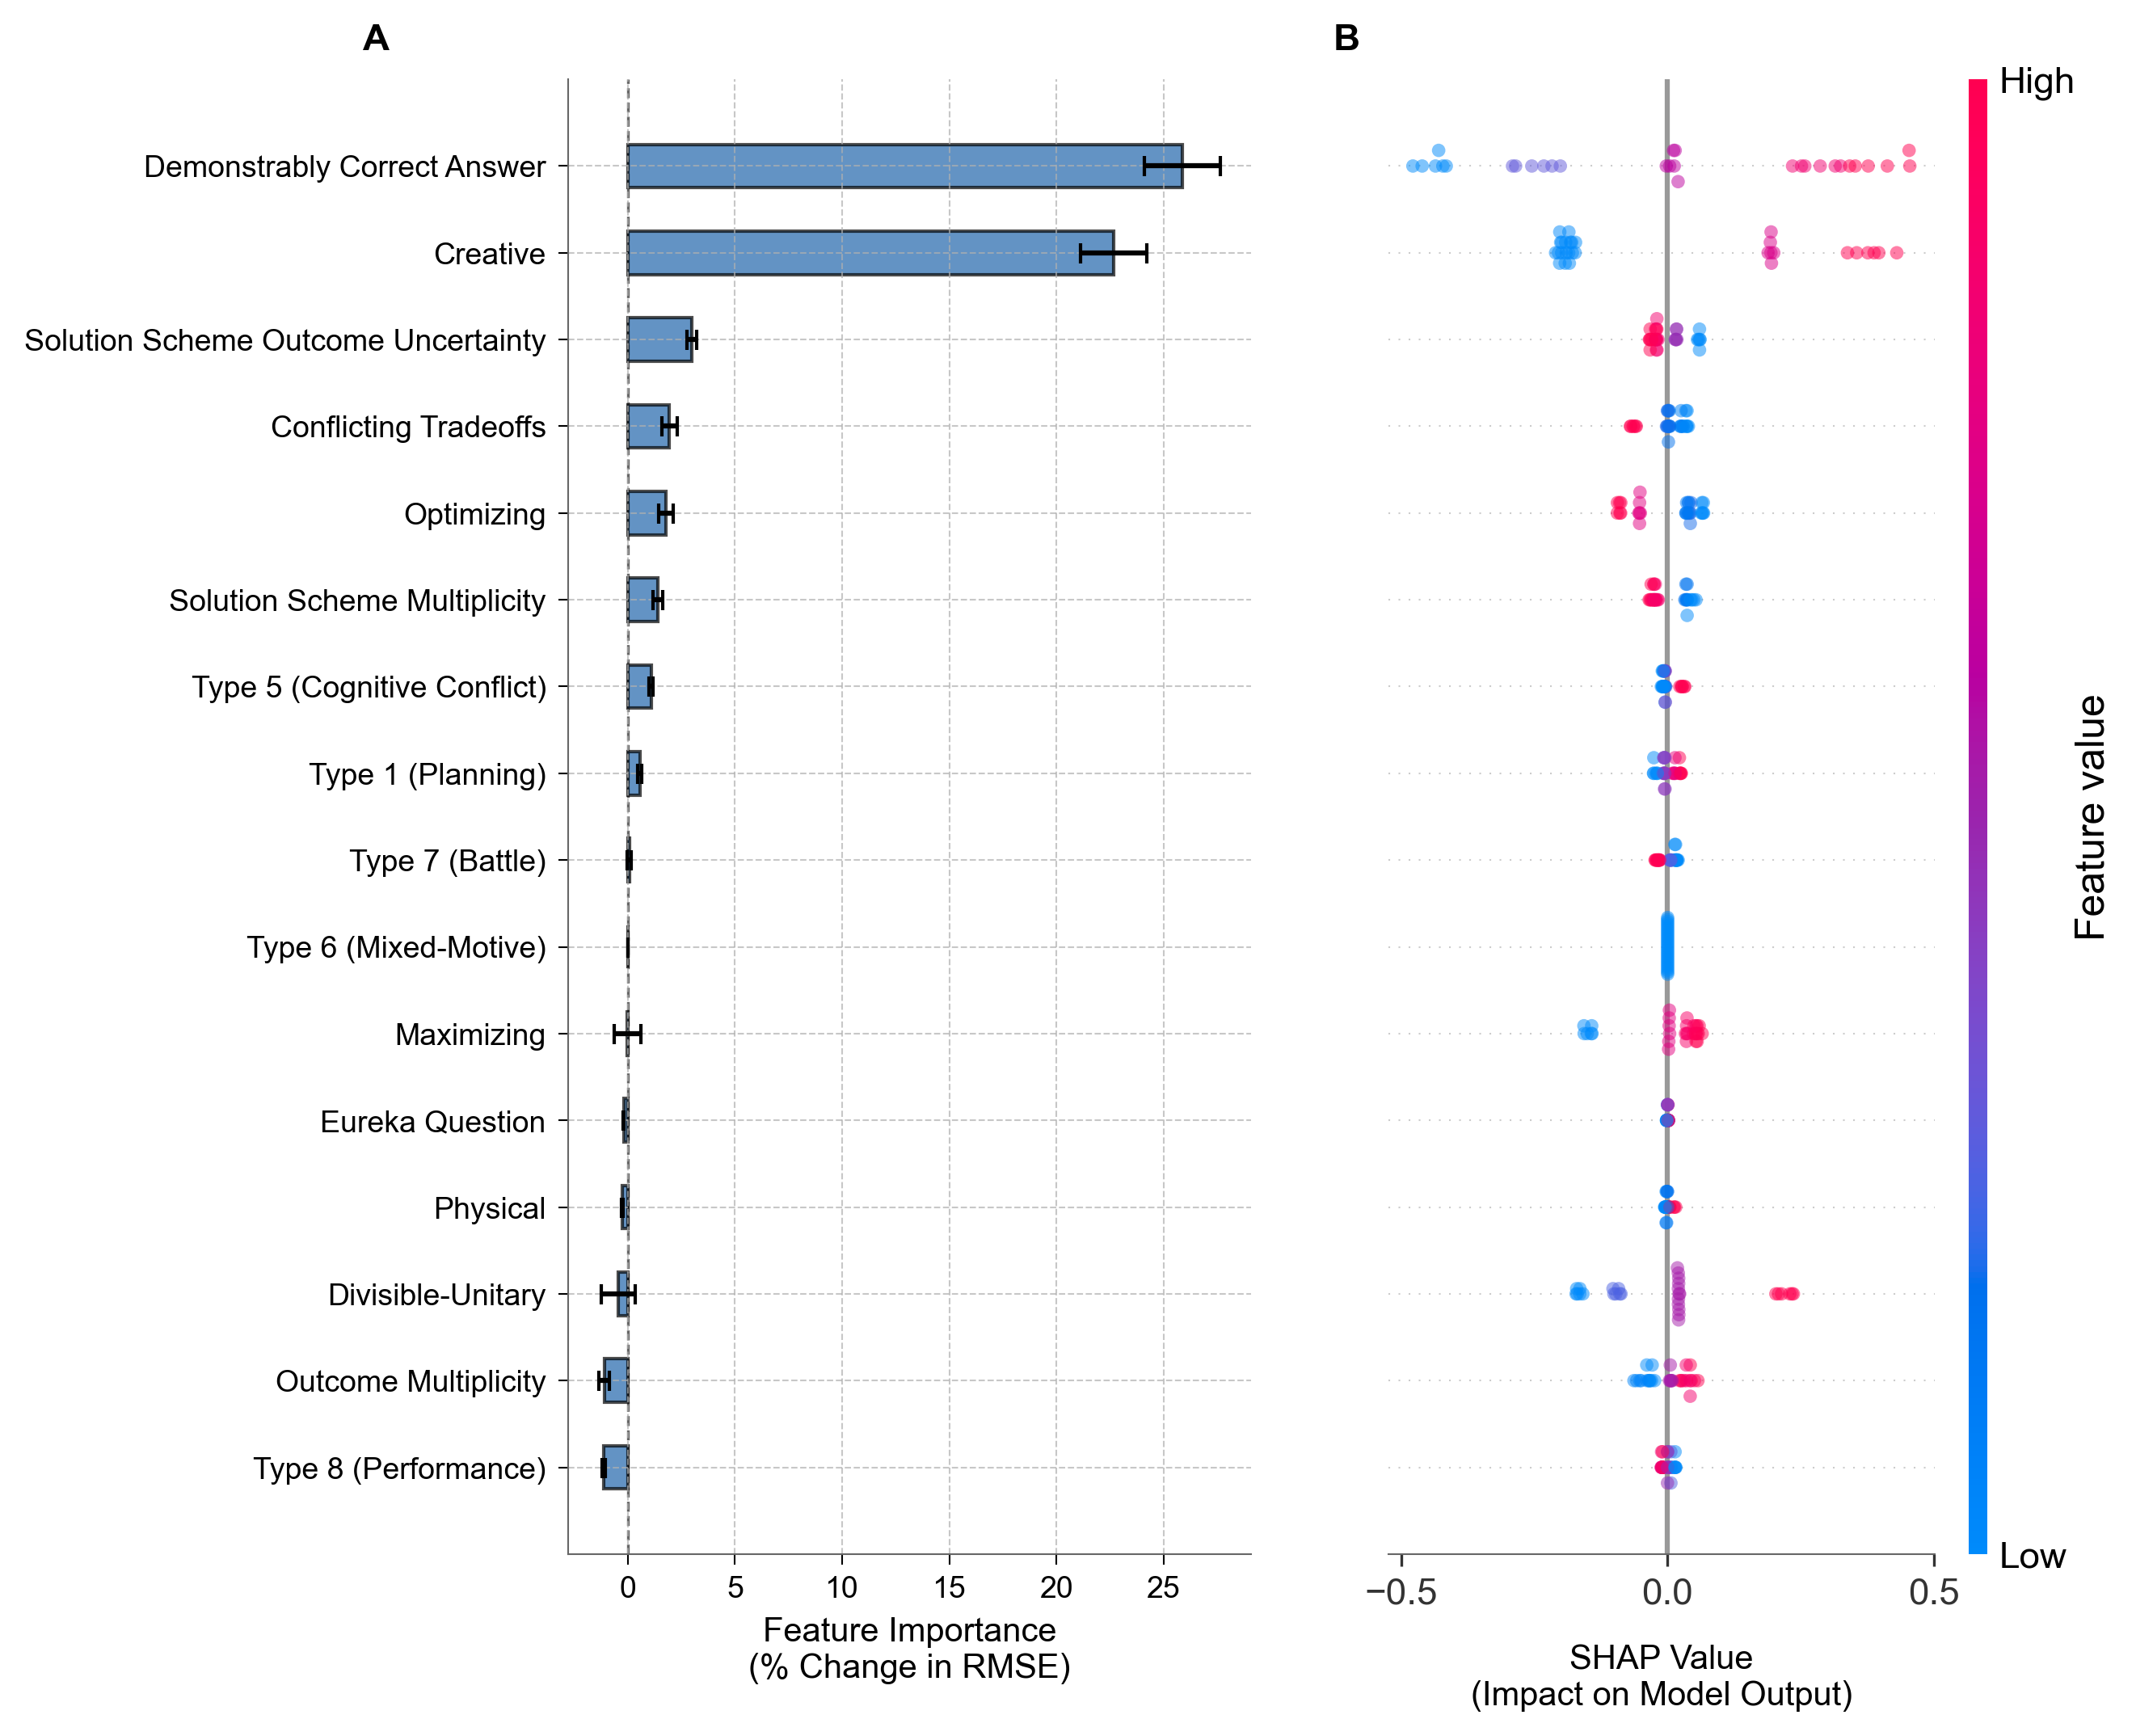

In [35]:
# Neural Network - Weak Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
	model = MODELS["Task Space NN"]["Weak (Train Waves 1-2, Predict Wave 3)"],
	wave_a_data = wave12_df_condition_level_data,
	wave_b_data = wave3_df_condition_level_data,
	ivs = basic_IVs,
	dv_type = "weak",
	model_type = "NN",
	save_path = '../outputs/combined_importance_nn_weak_wave3.png'
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

PermutationExplainer explainer:  37%|███▋      | 11/30 [00:00<?, ?it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


PermutationExplainer explainer:  43%|████▎     | 13/30 [00:11<00:09,  1.81it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  47%|████▋     | 14/30 [00:12<00:08,  1.80it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


PermutationExplainer explainer:  50%|█████     | 15/30 [00:13<00:09,  1.58it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


PermutationExplainer explainer:  53%|█████▎    | 16/30 [00:13<00:08,  1.71it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


PermutationExplainer explainer:  57%|█████▋    | 17/30 [00:14<00:07,  1.81it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


PermutationExplainer explainer:  60%|██████    | 18/30 [00:14<00:06,  1.85it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:  63%|██████▎   | 19/30 [00:15<00:05,  1.93it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|██████▋   | 20/30 [00:15<00:05,  1.81it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


PermutationExplainer explainer:  70%|███████   | 21/30 [00:16<00:05,  1.70it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  73%|███████▎  | 22/30 [00:16<00:04,  1.80it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


PermutationExplainer explainer:  77%|███████▋  | 23/30 [00:17<00:03,  1.86it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


PermutationExplainer explainer:  80%|████████  | 24/30 [00:17<00:03,  1.89it/s]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


PermutationExplainer explainer:  83%|████████▎ | 25/30 [00:18<00:02,  1.93it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


PermutationExplainer explainer:  87%|████████▋ | 26/30 [00:18<00:02,  1.95it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  90%|█████████ | 27/30 [00:19<00:01,  1.99it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


PermutationExplainer explainer:  93%|█████████▎| 28/30 [00:19<00:01,  1.97it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


PermutationExplainer explainer:  97%|█████████▋| 29/30 [00:20<00:00,  2.03it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


PermutationExplainer explainer: 100%|██████████| 30/30 [00:20<00:00,  2.07it/s]

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


PermutationExplainer explainer: 31it [00:21,  1.07s/it]                        


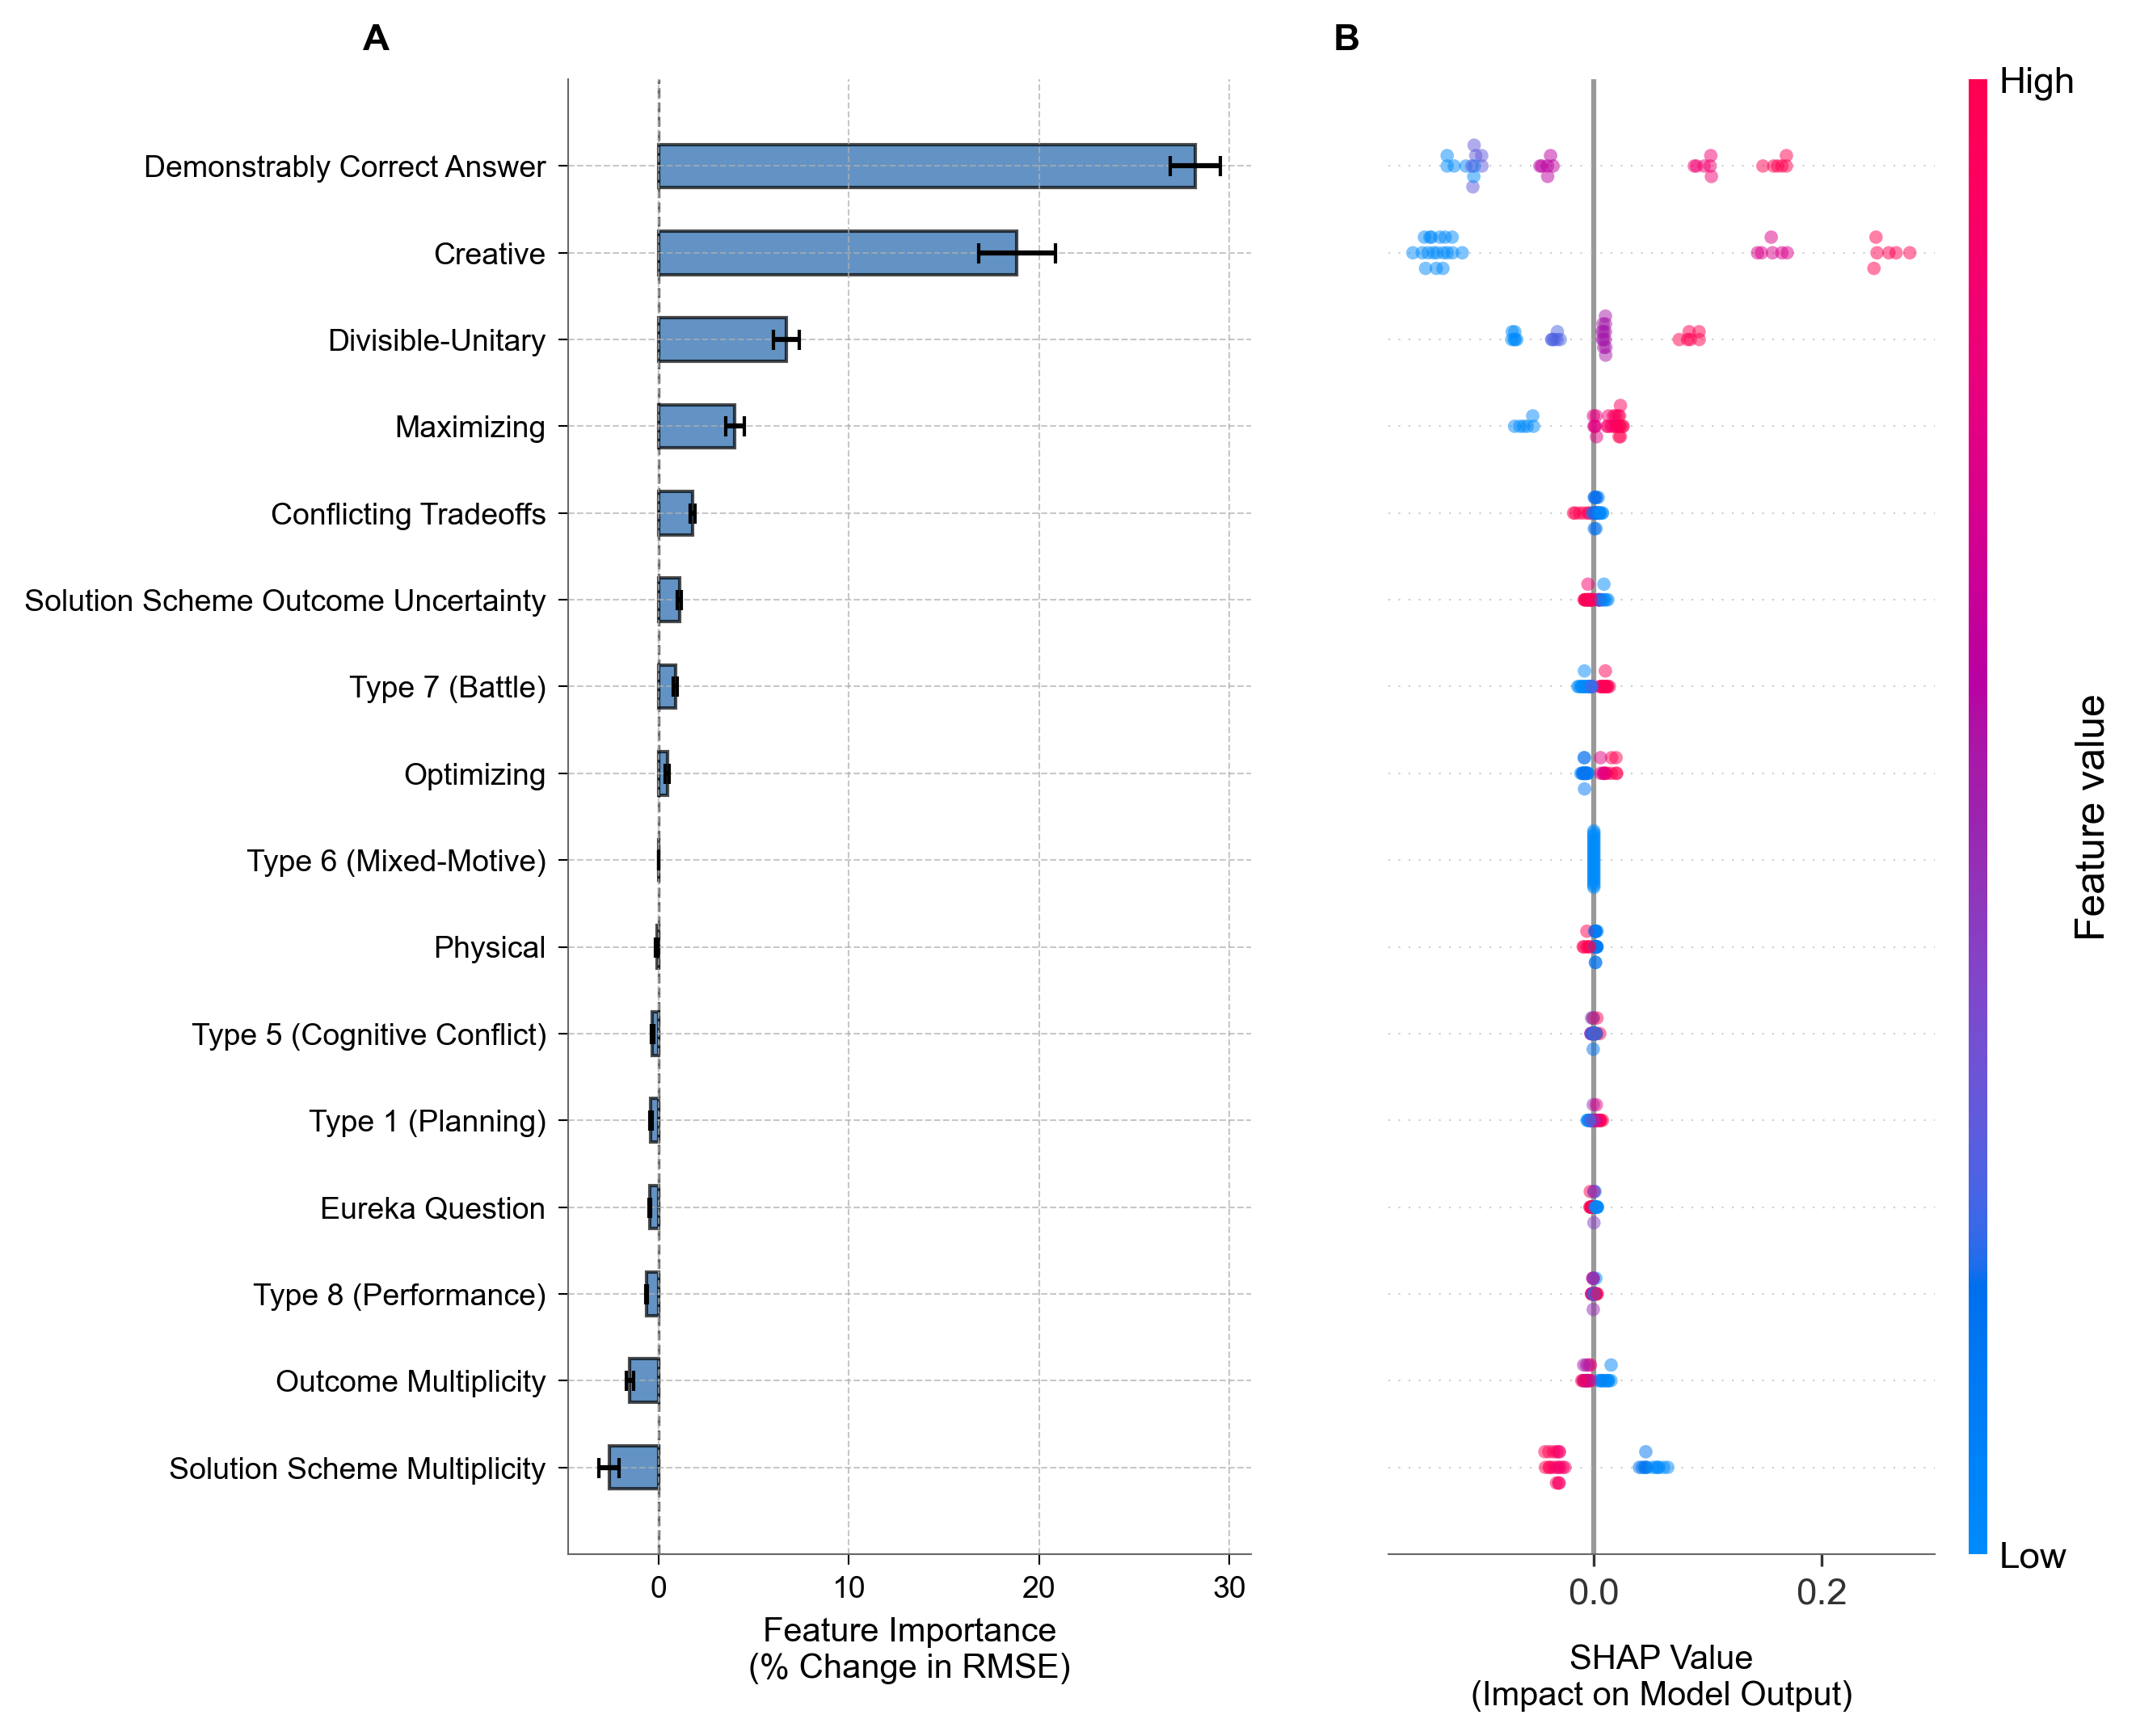

In [36]:
# Neural Network - Strong Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
	model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
	wave_a_data = wave12_df_condition_level_data,
	wave_b_data = wave3_df_condition_level_data,
	ivs = basic_IVs,
	dv_type = "strong",
	model_type = "NN",
	save_path = '../outputs/combined_importance_nn_strong_wave3.png'
)

# Check Model Predictions with Preregistration

## Train on Wave 1, Predict on Wave 2

In [37]:
task_information_wave2 = wave2_df_condition_level_data[["task", "High", "Medium", "Low", "playerCount"]]
weak_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
              X = wave2_df_condition_level_data[basic_IVs],
              model_type = "NN")
weak_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"], 
              X = wave2_df_condition_level_data[basic_IVs],
              model_type = "LM")
strong_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Wave 1, Predict Wave 2)"], 
              X = wave2_df_condition_level_data[basic_IVs],
              model_type = "NN")
strong_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Strong (Train Wave 1, Predict Wave 2)"], 
              X = wave2_df_condition_level_data[basic_IVs],
              model_type = "LM")
# add the model predictions to the dataframe
task_information_wave2["Weak NN Predictions"] = weak_model_predictions_nn.round(2)
task_information_wave2["Weak LM Predictions"] = weak_model_predictions_lm.round(2)
task_information_wave2["Strong NN Predictions"] = strong_model_predictions_nn.round(2)
task_information_wave2["Strong LM Predictions"] = strong_model_predictions_lm.round(2)
# add the mean of the training data to the dataframe
task_information_wave2["Weak Baseline"] = wave1_df_condition_level_data["weak"].mean().round(2)
task_information_wave2["Strong Baseline"] = wave1_df_condition_level_data["strong"].mean().round(2)

# order the tasks in the following order
order = ["Logic Problem", "Unscramble Words", "Random Dot Motion", "Recall Word Lists", "Typing"]
task_information_wave2["task"] = pd.Categorical(task_information_wave2["task"], categories=order, ordered=True)
task_information_wave2 = task_information_wave2.sort_values(by=["task",  "High", "Low", "Medium",  "playerCount"], ascending=[True, True, False, False, True])
task_information_wave2.reset_index(drop=True, inplace=True)


# merge in the original predictions
original_preds_wave2 = pd.read_csv('../original_predictions/wave2_preds.csv').rename(columns={"Task": "task",
                                                                         "Weak_NN": "Weak NN Predictions Original",
                                                                         "Strong_NN": "Strong NN Predictions Original",
                                                                         "Weak_LM": "Weak LM Predictions Original",
                                                                         "Strong_LM": "Strong LM Predictions Original",
                                                                         "Weak_Baseline": "Weak Baseline Original",
                                                                         "Strong_Baseline": "Strong Baseline Original"})
# get dummies for complexity in original_preds_wave2 with NO prefix
original_preds_wave2 = pd.get_dummies(original_preds_wave2, columns=["Complexity"], prefix="", prefix_sep="")
task_information_wave2 = pd.merge(task_information_wave2, original_preds_wave2, on=['task', 'High', 'Medium', 'Low', 'playerCount'], how='inner')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


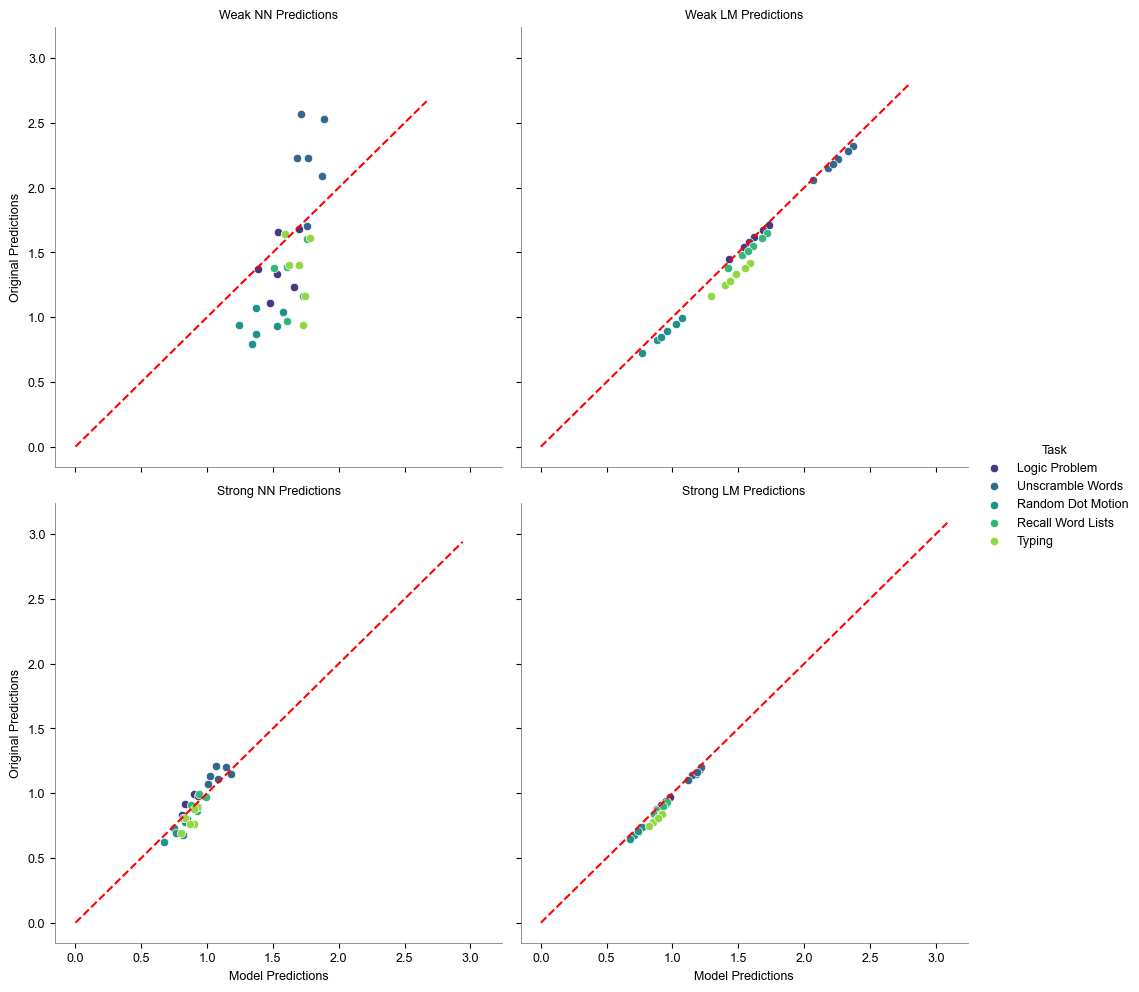

In [38]:
def plot_prediction_differences(task_info_df, wave):
    pred_cols = [
        "Weak NN Predictions", "Weak LM Predictions",
        "Strong NN Predictions", "Strong LM Predictions"
    ]
    original_cols = [col + " Original" for col in pred_cols]

    task_information_long = pd.concat([
        pd.DataFrame({
            'task': task_info_df['task'],
            'prediction_type': pred,
            'Model Predictions': task_info_df[pred],
            'Original Predictions': task_info_df[orig]
        })
        for pred, orig in zip(pred_cols, original_cols)
    ], ignore_index=True)

    palette = sns.color_palette("viridis", len(task_info_df['task'].unique()))
    g = sns.FacetGrid(
        task_information_long, col='prediction_type', col_wrap=2, height=5, aspect=1, hue='task', palette=palette
    )
    g.map_dataframe(sns.scatterplot, x='Model Predictions', y='Original Predictions')

    # Add diagonal lines
    for ax in g.axes.flatten():
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')

    g.add_legend(title="Task")
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Model Predictions", "Original Predictions")
    plt.savefig('../outputs/prediction_differences_wave' + str(wave) + '.png')
    plt.show()

plot_prediction_differences(task_information_wave2, wave = 2)

## Train on Waves 1-2, Predict on Wave 3

In [39]:
task_information_wave3 = wave3_df_condition_level_data[["task", "High", "Medium", "Low", "playerCount"]]
weak_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
              X = wave3_df_condition_level_data[basic_IVs],
                model_type = "NN")
weak_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"], 
              X = wave3_df_condition_level_data[basic_IVs],
              model_type = "LM")
strong_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
                X = wave3_df_condition_level_data[basic_IVs],
                model_type = "NN")
strong_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Strong (Train Waves 1-2, Predict Wave 3)"],
                X = wave3_df_condition_level_data[basic_IVs],
                model_type = "LM")
# add the model predictions to the dataframe
task_information_wave3["Weak NN Predictions"] = weak_model_predictions_nn.round(2)
task_information_wave3["Weak LM Predictions"] = weak_model_predictions_lm.round(2)
task_information_wave3["Strong NN Predictions"] = strong_model_predictions_nn.round(2)
task_information_wave3["Strong LM Predictions"] = strong_model_predictions_lm.round(2)
# add the mean of the training data to the dataframe
task_information_wave3["Weak Baseline"] = wave12_df_condition_level_data["weak"].mean().round(2)
task_information_wave3["Strong Baseline"] = wave12_df_condition_level_data["strong"].mean().round(2)

# order the tasks in the following order
order = ["Wildcat Wells", "WildCam", "Recall Association", "Advertisement Writing", "Putting Food Into Categories"]
task_information_wave3["task"] = pd.Categorical(task_information_wave3["task"], categories=order, ordered=True)
task_information_wave3 = task_information_wave3.sort_values(by=["task",  "High", "Low", "Medium",  "playerCount"], ascending=[True, True, False, False, True])
task_information_wave3.reset_index(drop=True, inplace=True)

# merge in the original predictions
original_preds_wave3 = pd.read_csv('../original_predictions/wave3_preds.csv').rename(columns={"Task": "task",
                                                                         "Weak_NN": "Weak NN Predictions Original",
                                                                         "Strong_NN": "Strong NN Predictions Original",
                                                                         "Weak_LM": "Weak LM Predictions Original",
                                                                         "Strong_LM": "Strong LM Predictions Original",
                                                                         "Weak_Baseline": "Weak Baseline Original",
                                                                         "Strong_Baseline": "Strong Baseline Original"})
original_preds_wave3 = pd.get_dummies(original_preds_wave3, columns=["Complexity"], prefix="", prefix_sep="")
task_information_wave3 = pd.merge(task_information_wave3, original_preds_wave3, on=['task', 'High', 'Medium', 'Low', 'playerCount'], how='inner')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


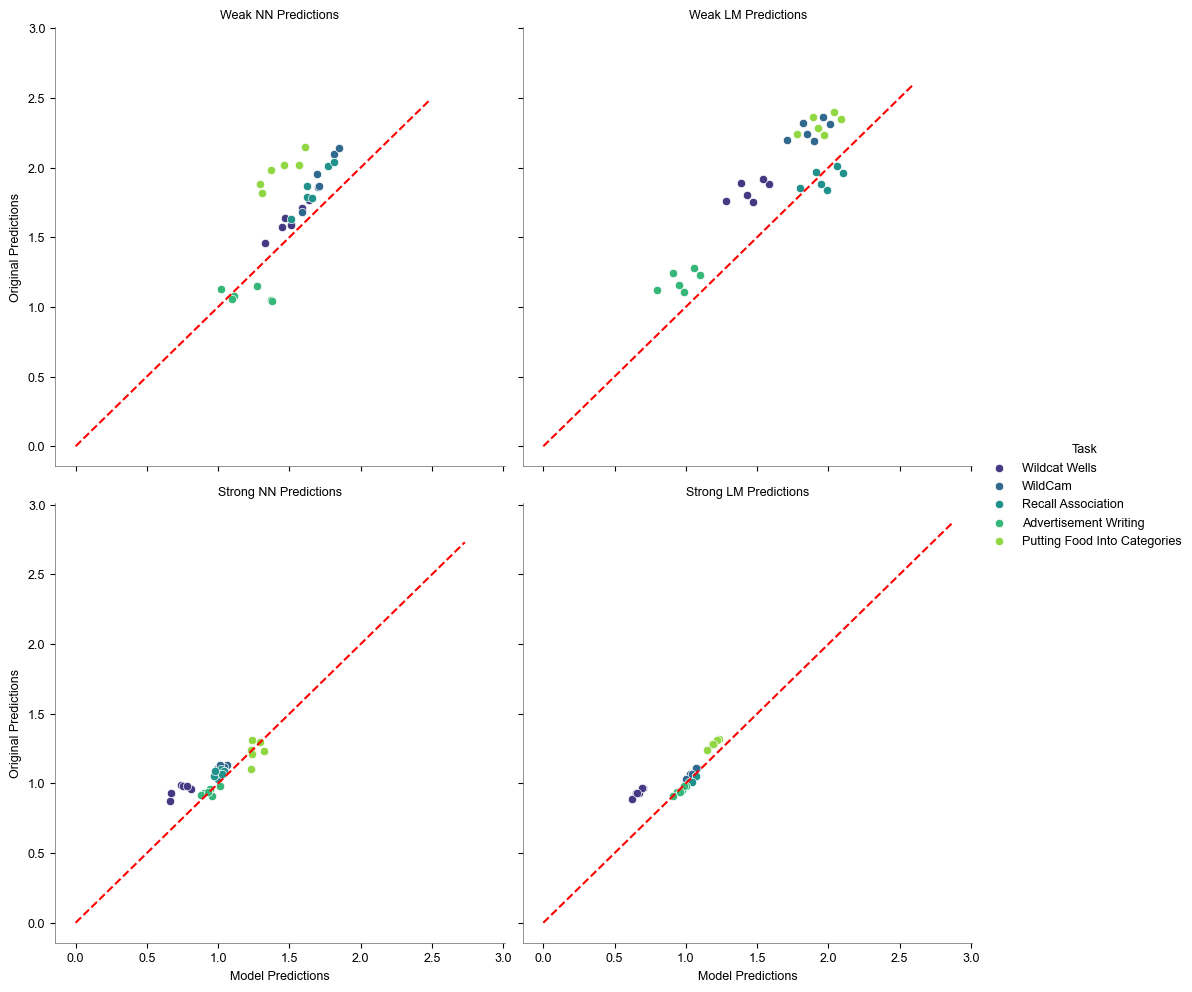

In [40]:
plot_prediction_differences(task_information_wave3, wave = 3)

# Prediction for New Conditions

In [41]:
df_future_tasks = pd.read_csv('../future_predictions/future_tasks_for_prediction.csv')

In [42]:
weak_model_predictions_nn_future = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
              X = df_future_tasks[basic_IVs],
                model_type = "NN")
strong_model_predictions_nn_future = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
                X = df_future_tasks[basic_IVs],
                model_type = "NN")

future_predictions =  df_future_tasks[["task", "High", "Medium", "Low", "playerCount"]]
# append the future predictions as "strong_prediction" and "weak_prediction"
future_predictions["Weak Prediction"] = weak_model_predictions_nn_future.round(2)
future_predictions["Strong Prediction"] = strong_model_predictions_nn_future.round(2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


In [43]:
future_predictions.to_csv('../future_predictions/future_tasks_predictions.csv')